In [1]:
# Disable GPU
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import os
import sys
import glob
import json
import pickle
import copy
import itertools
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, ScalarFormatter

from IPython.display import display

try:
    import bayesflow as bf
except ModuleNotFoundError:  
    sys.path.extend([
        os.path.abspath(os.path.join("../..")),
        os.path.abspath(os.path.join("../../BayesFlow_dev/BayesFlow/"))
    ])
    import bayesflow as bf

import functions_param_estim as prior_simulator_functions

#%load_ext autoreload
#%autoreload 2

2025-05-22 17:50:21.582938: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/administrator/miniconda3/envs/bf/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Check Functions

In [3]:
params = prior_simulator_functions.levy_prior(False, 32)[1]
params

array([ 0.366903  ,  0.03090425,  0.56780773, -5.40196   ,  5.538373  ,
        1.1867706 ,  1.3240931 ], dtype=float32)

In [4]:
ndt, st0, zr, v0, v1, a, alpha = params
prior_simulator_functions.diffusion_trial(ndt, st0, zr, v0, a, alpha, False)

-1.512155474163622

In [5]:
prior_simulator_functions.ddm_simulator(params, 10, deadline=False)

array([[ 0.43950492,  0.        ],
       [-0.51686945,  0.        ],
       [-0.48798692,  0.        ],
       [-0.47050848,  0.        ],
       [-0.48106802,  0.        ],
       [-0.45499366,  1.        ],
       [ 0.45050755,  1.        ],
       [ 0.4146137 ,  1.        ],
       [ 0.44621369,  1.        ],
       [ 0.5045626 ,  1.        ]])

# Set Constants

In [6]:
# Generative model
PARAM_NAMES = ['t0', 'st0', 'zr', 'v0',  'v1', 'a', 'alpha']
PARAM_LABELS = [r"$t_0$", r"$s_{t_0}$", r"$z_r$", r"$v_{0}$", r"$v_{1}$", r"$a$", r"$\alpha$"]
PRIOR_CONTEXTS =  ["levy", "ddm"]
model_map = {"levy": "Lévy-flight", "ddm": "diffusion"}
SIMULATOR_CONTEXTS = ["deadline"] #["no_deadline", "deadline"]

# Neural networks
NUM_ENSEMBLE_MEMBERS = 2
NUM_ITERATIONS_PER_EPOCH = 10000
BATCH_SIZE = 32
SUMMARY_NET_SETTINGS = {
    "summary_dim" : 20, #16,
    "num_dense_s1" : 3,
    "num_dense_s2" : 3,
    "num_dense_s3" : 3,
    "num_dense_equivariant" : 3
}

# Validation
NUM_COMBINATIONS = len(PRIOR_CONTEXTS) * len(SIMULATOR_CONTEXTS)
NUM_VAL_SIMS_PER_COMBINATION = 500
NUM_VAL_SAMPLES = 1000
NUM_VAL_OBS = 400

# Global
if NUM_COMBINATIONS==4:
    NUM_EPOCHS = 500
elif NUM_COMBINATIONS==2:
    NUM_EPOCHS = 250
else:
    NUM_EPOCHS = 125
TRAINING_MODE = "presimulation" #online
MY_NAME = "ttj_" + TRAINING_MODE + "_" + str(NUM_EPOCHS) + "ep_" + str(NUM_ITERATIONS_PER_EPOCH) + 'it_' + '_'.join(PRIOR_CONTEXTS + SIMULATOR_CONTEXTS) 
MY_DPI = 200 #600

# Presimulation (irrelevant if online training is used)
RUNNER = "pc2" #"pc1"
PRESIM_PATH = "/media/administrator/Expansion/"
NUM_PROCESSES = 25 

print(MY_NAME)

ttj_presimulation_250ep_10000it_levy_ddm_deadline


# Generative Model

Careful: Context is implemented batch-wise, so all data sets of a batch will have the same context. 
I.e., the same number of observations, the same computational model (Levy or DDM), and the same deadline condition (no deadline or deadline).
That means that e.g., generative_model(1000) will simulate all data sets from a single combination of those constellations!
See validation part below for getting samples under all combinations.

In [7]:
def binary_context_generator():
    """ 
    Generates binary context indicators for joint parameter estimation.
    Prior context: 0 = Levy, 1 = DDM.
    Simulator context: 0 = no deadline, 1 = deadline.
    """
    return np.random.binomial(n=1, p=0.5)
def prior_context_generator():
    """
    Generates a fixed context indicator based on the global PRIOR_CONTEXTS variable.
    Returns:
        int: Fixed context value (0 for "levy", 1 for "ddm").
    """
    return 0 if PRIOR_CONTEXTS == ["levy"] else 1
def simulator_context_generator():
    """
    Generates a fixed context indicator based on the global SIMULATOR_CONTEXTS variable.
    Returns:
        int: Fixed context value (0 for "no_deadline", 1 for "deadline").
    """
    return 0 if SIMULATOR_CONTEXTS == ["no_deadline"] else 1

In [8]:
# Determine the appropriate context generator functions based on the number of combinations
# and potentially the length of context-specific lists (PRIOR_CONTEXTS).
if NUM_COMBINATIONS == 1:
    # Use dedicated context generators for debugging or single-context scenarios.
    prior_fun = prior_context_generator
    simulator_fun = simulator_context_generator
elif NUM_COMBINATIONS == 2:
    # Choose between specific or binary context generators based on the length of PRIOR_CONTEXTS.
    # This allows for a mix of deterministic and randomized contexts depending on the setup.
    prior_fun = prior_context_generator if len(PRIOR_CONTEXTS) == 1 else binary_context_generator
    simulator_fun = binary_context_generator if len(PRIOR_CONTEXTS) == 1 else simulator_context_generator
else:  # NUM_COMBINATIONS == 4
    # In scenarios requiring a broader range of combinations, use binary context generators for both.
    prior_fun = simulator_fun = binary_context_generator

In [9]:
# Assign the context generators to create the context generator objects.
my_prior_context_generator = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_fun)
my_simulator_context_generator = bf.simulation.ContextGenerator(non_batchable_context_fun=simulator_fun) if NUM_COMBINATIONS != 4 else my_prior_context_generator

# Prior
prior = bf.simulation.Prior(
    batch_prior_fun=prior_simulator_functions.levy_prior, 
    context_generator=my_prior_context_generator,
    param_names=PARAM_NAMES
)

# Simulator
simulator = bf.simulation.Simulator(
    batch_simulator_fun=prior_simulator_functions.batch_simulator,
    context_generator=my_simulator_context_generator
)

# Combine the prior and simulator into a GenerativeModel.
generative_model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 396, 2)
INFO:root:Could not determine shape of prior non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation batchable context provided.


In [10]:
prior(batch_size=2)  # For the DDM, alpha = 2 during simulation -> replaced by a sample from dummy standard normal during configuration

{'prior_draws': array([[ 0.23767434,  0.11076979,  0.3484884 , -1.3413395 ,  4.32822   ,
          0.68638515,  2.        ],
        [ 0.22548062,  0.10096388,  0.50161606, -5.2885346 ,  2.7211492 ,
          0.92945445,  2.        ]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': 1}

In [11]:
sim_data = generative_model(batch_size=2)
sim_data

{'prior_non_batchable_context': 0,
 'prior_batchable_context': None,
 'prior_draws': array([[ 0.41462943,  0.12194824,  0.6694692 , -2.93448   ,  2.045591  ,
          1.4045762 ,  1.4514062 ],
        [ 0.3359884 ,  0.04710848,  0.49748167, -3.1531904 ,  3.3649676 ,
          1.4139916 ,  1.7573475 ]], dtype=float32),
 'sim_non_batchable_context': 1,
 'sim_batchable_context': None,
 'sim_data': array([[[ 0.        ,  0.        ],
         [ 0.4535201 ,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  1.        ],
         [ 0.        ,  1.        ],
         [ 0.43935412,  1.        ]],
 
        [[-0.4018589 ,  0.        ],
         [-0.48813602,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  1.        ],
         [ 0.        ,  1.        ],
         [ 0.41839045,  1.        ]]], dtype=float32)}

# Prior Checks

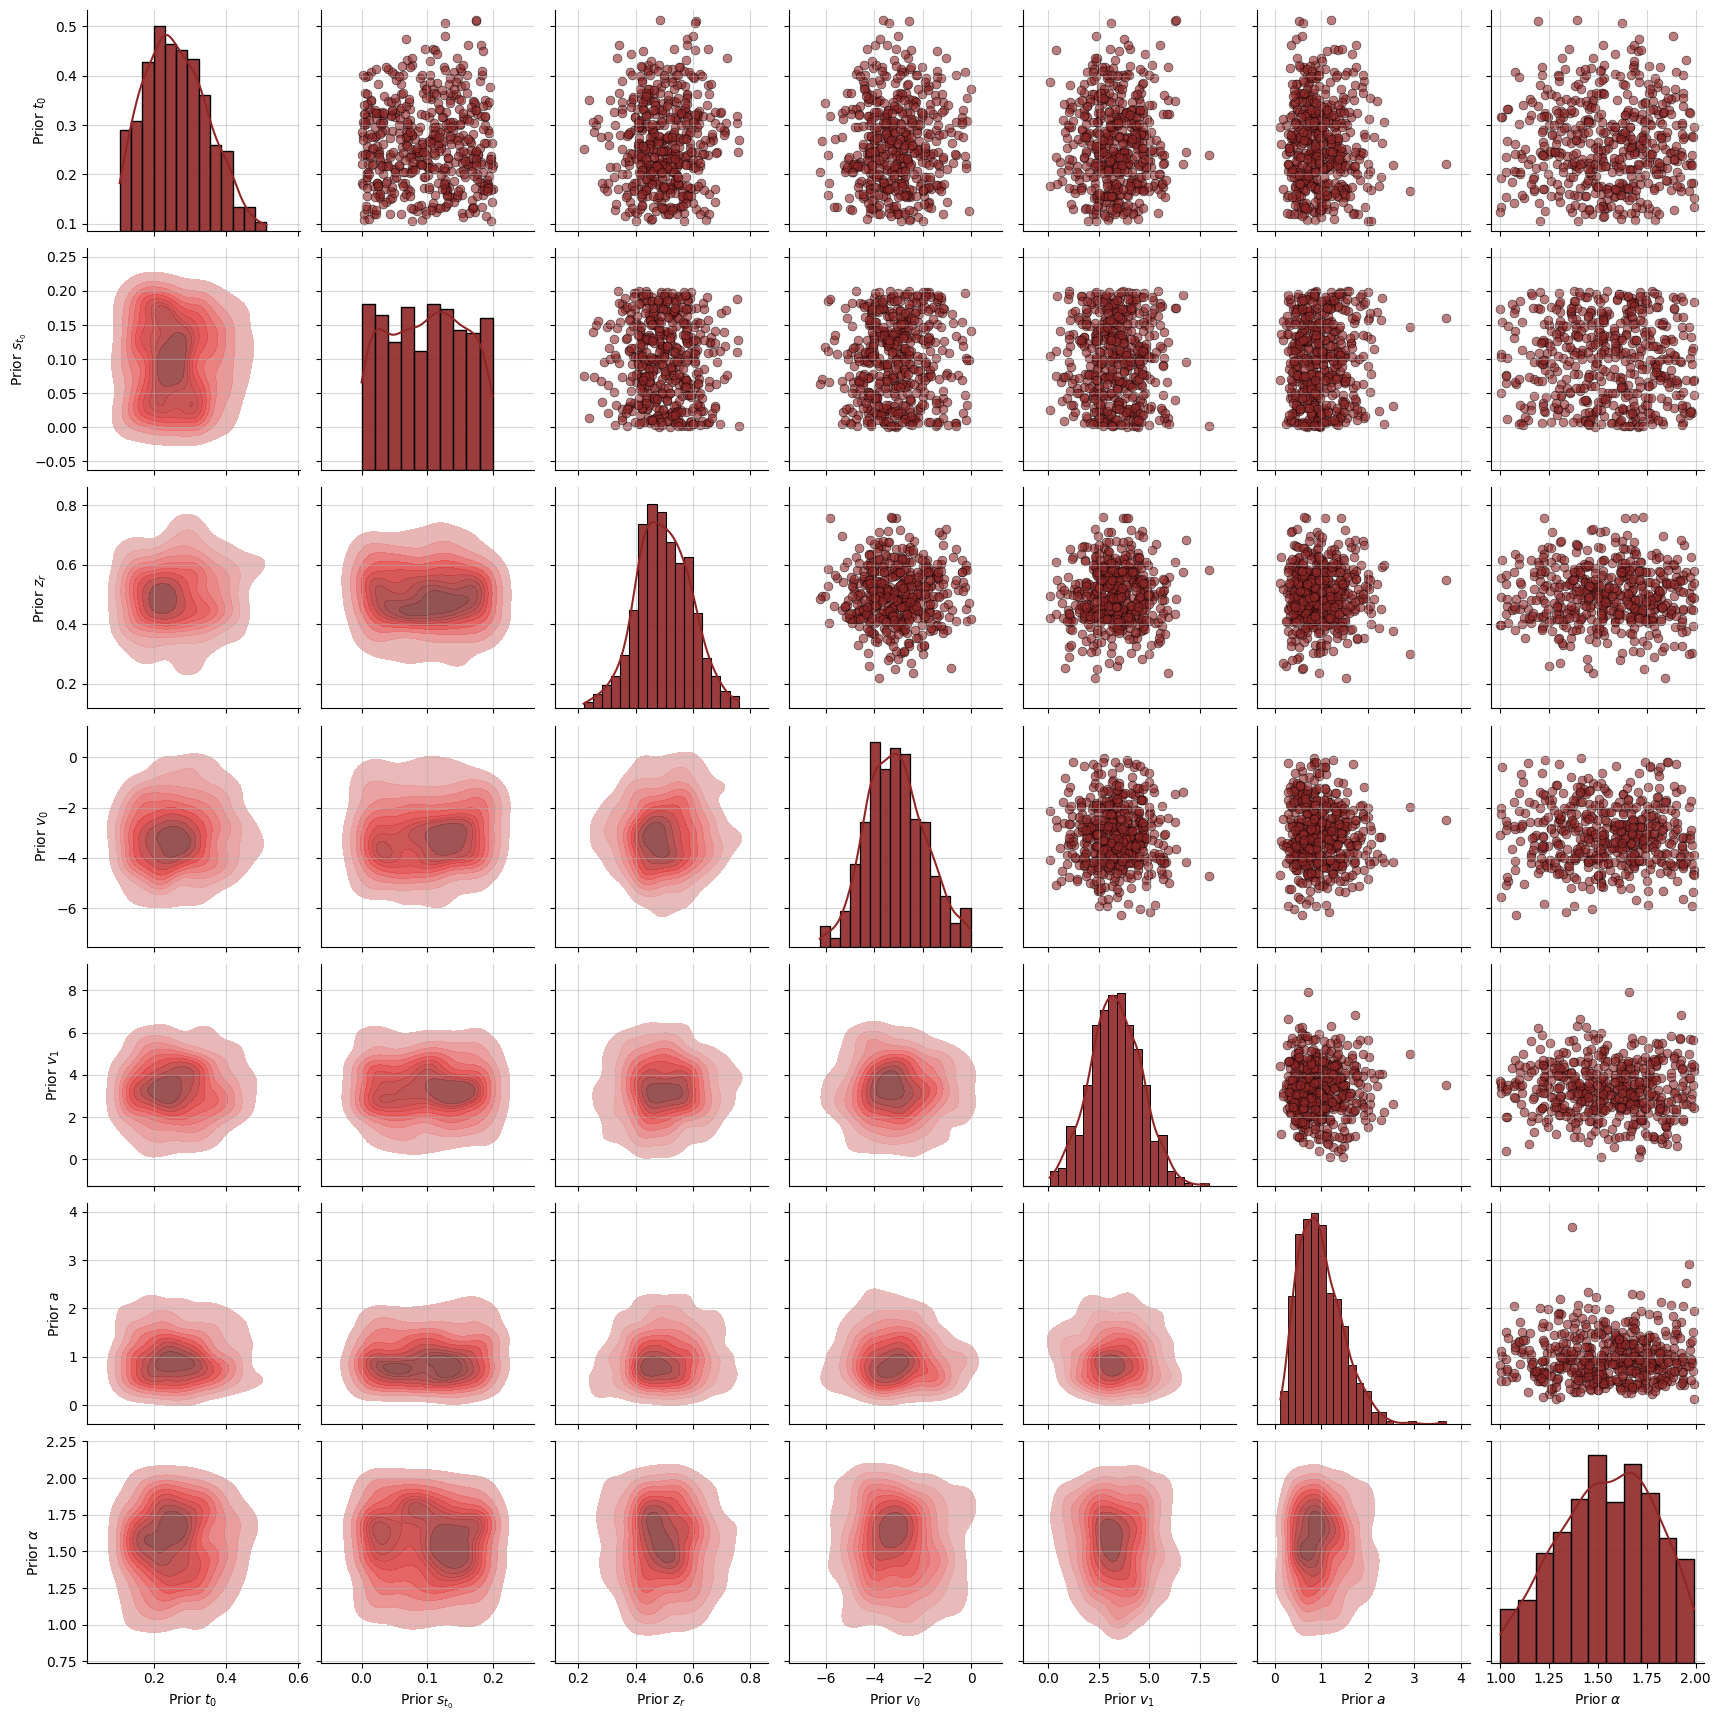

In [12]:
check_levy_prior = bf.simulation.Prior(
    batch_prior_fun=prior_simulator_functions.levy_prior, 
    context_generator=bf.simulation.ContextGenerator(non_batchable_context_fun=lambda: 0),
    param_names=PARAM_LABELS)
plot = check_levy_prior.plot_prior2d(n_samples=500)

# Prior Push Forward Check

In [13]:
#SIMULATOR_CONTEXTS ="deadline"
if NUM_COMBINATIONS == 1:
    context_combinations = [(prior_context_generator(), simulator_context_generator())]
elif NUM_COMBINATIONS == 2:
    if len(PRIOR_CONTEXTS) == 1:
        context_combinations = [(prior_context_generator(), sim_context) for sim_context in range(len(SIMULATOR_CONTEXTS))]
    else:
        context_combinations = [(prior_context, simulator_context_generator()) for prior_context in range(len(PRIOR_CONTEXTS))]
else:  # NUM_COMBINATIONS == 4 or more complex cases
    context_combinations = list(itertools.product(range(len(PRIOR_CONTEXTS)), range(len(SIMULATOR_CONTEXTS))))

In [14]:
my_batch_size = 500  
all_rows = []

for prior_context, sim_context in context_combinations:
    check_prior = bf.simulation.Prior(
        batch_prior_fun=prior_simulator_functions.levy_prior,
        context_generator=bf.simulation.ContextGenerator(non_batchable_context_fun=lambda: prior_context),
        param_names=PARAM_NAMES
    )
    check_simulator = bf.simulation.Simulator(
        batch_simulator_fun=prior_simulator_functions.batch_simulator,
        context_generator=bf.simulation.ContextGenerator(non_batchable_context_fun=lambda: sim_context)
    )

    check_generative_model = bf.simulation.GenerativeModel(prior=check_prior, simulator=check_simulator)
    sim_rts = check_generative_model(batch_size=my_batch_size)['sim_data']  

    df = pd.DataFrame({
        'pp': np.repeat(np.arange(my_batch_size), sim_rts.shape[1]),
        'RT': sim_rts[:, :, 0].flatten(),
        'symbol': sim_rts[:, :, 1].astype(int).flatten(),
        'prior': prior_context,
        'simulator': sim_context
    })

    cond1 = (df['RT'] < 0) & (df['symbol'] == 1)
    cond2 = (df['RT'] > 0) & (df['symbol'] == 1)
    cond3 = (df['RT'] < 0) & (df['symbol'] == 0)
    cond4 = (df['RT'] > 0) & (df['symbol'] == 0)

    df['correct'] = np.nan
    df.loc[cond1, 'correct'] = 0
    df.loc[cond2, 'correct'] = 1
    df.loc[cond3, 'correct'] = 1
    df.loc[cond4, 'correct'] = 0
    df['correct'] = df['correct'].astype('Int64')

    df.loc[df['RT'] == 0, 'RT'] = np.nan
    df['RT'] = abs(df['RT'])

    for pp, group in df.groupby('pp'):
        RTs_correct = group.loc[group['correct'] == 1, 'RT']
        RTs_incorrect = group.loc[group['correct'] == 0, 'RT']
        
        mean_corr = RTs_correct.mean() if not RTs_correct.empty else np.nan
        mean_incorr = RTs_incorrect.mean() if not RTs_incorrect.empty else np.nan  
        mean_diff = mean_corr - mean_incorr if pd.notnull(mean_corr) and pd.notnull(mean_incorr) else np.nan

        skew_corr = skew(RTs_correct, bias=False) if RTs_correct.size > 2 else np.nan
        skew_incorr = skew(RTs_incorrect, bias=False) if RTs_incorrect.size > 2 else np.nan

        acc = group['correct'].mean()
        prop_timeout = group['RT'].isna().mean()
        
        all_rows.append({
            'prior': prior_context,
            'simulator': sim_context,
            'pp': pp,
            'meanRT_corr': mean_corr,
            'meanRT_incorr': mean_incorr,
            'meanRT_diff': mean_diff,
            'skew_corr': skew_corr,
            'skew_incorr': skew_incorr,
            'acc': acc,
            'prop_timeout': prop_timeout
        })

df_results = pd.DataFrame(all_rows)

df_results['is_sym_corr'] = df_results['skew_corr'].between(-1, 1)
df_results['is_sym_incorr'] = df_results['skew_incorr'].between(-1, 1)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 385, 2)
INFO:root:Could not determine shape of prior non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 419, 2)
IN

In [15]:
my_vars = ['pp', 'prior', 'simulator', 'prop_timeout', 'is_sym_corr', 'acc']

df_rt = pd.melt(df_results, id_vars=my_vars, value_vars=['meanRT_corr', 'meanRT_incorr'], var_name='corr', value_name='rt')
df_rt['corr'] = df_rt['corr'].str.replace('meanRT_', '')

df_skew = pd.melt(df_results, id_vars=my_vars, value_vars=['skew_corr', 'skew_incorr'], var_name='corr', value_name='skew')
df_skew['corr'] = df_skew['corr'].str.replace('skew_', '')

df_long = pd.merge(df_rt, df_skew, on=my_vars + ['corr'])

In [16]:
min_corr = df_long[df_long['corr'] == 'corr']['rt'].min()
max_corr = df_long[df_long['corr'] == 'corr']['rt'].max()
min_incorr = df_long[df_long['corr'] == 'incorr']['rt'].min()
max_incorr = df_long[df_long['corr'] == 'incorr']['rt'].max()
min_rt = min(min_corr, min_incorr)
max_rt = max(max_corr, max_incorr)

min_corr = df_long[df_long['corr'] == 'corr']['skew'].min()
max_corr = df_long[df_long['corr'] == 'corr']['skew'].max()
min_incorr = df_long[df_long['corr'] == 'incorr']['skew'].min()
max_incorr = df_long[df_long['corr'] == 'incorr']['skew'].max()
min_skew = min(min_corr, min_incorr)
max_skew = max(max_corr, max_incorr)

min_acc = df_long[df_long['corr'] == 'corr']['acc'].min()
max_acc = df_long[df_long['corr'] == 'corr']['acc'].max()

Timeout Modeling:  Present
Timeout Modeling:  Present


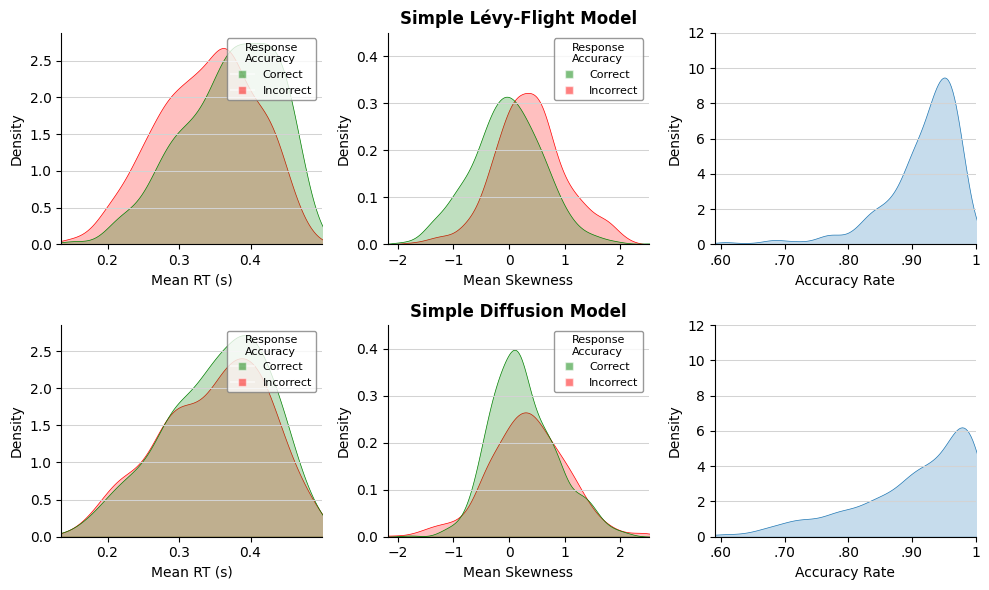

In [17]:
def apa_tick_formatter(digits=1):
    def formatter(x, _):
        if x == int(x):
            return str(int(x))
        else:
            return f'{x:.{digits}f}'.lstrip('0') 
    return formatter

prior_map = {0: "Simple Lévy-Flight Model", 1: "Simple Diffusion Model"}
simulator_map = {0: "Absent", 1: "Present"}
combinations = df_long[['prior', 'simulator']].drop_duplicates().sort_values(['prior', 'simulator']).values

n_rows = len(combinations)
fig, axs = plt.subplots(n_rows, 3, figsize=(10, 3 * n_rows), sharex=0)

if n_rows == 1:
    axs = [axs]

for i, (prior_val, sim_val) in enumerate(combinations):
    subset = df_long[(df_long['prior'] == prior_val) & (df_long['simulator'] == sim_val)]
    prior_label = prior_map[prior_val]
    simulator_label = simulator_map[sim_val]
    print("Timeout Modeling: ", simulator_label)

    # RT plot 
    sns.kdeplot(
        data=subset, x='rt', hue='corr', ax=axs[i][0],
        fill=True, lw=0.5, palette={'corr': 'green', 'incorr': 'red'}, legend=0
    )
    axs[i][0].grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    axs[i][0].spines['top'].set_visible(False)
    axs[i][0].spines['right'].set_visible(False)
    axs[i][0].set_xlim([min_rt, max_rt])
    axs[i][0].set_xlabel('Mean RT (s)')

    legend_items = [mlines.Line2D([0], [0], marker='s', color='w', label="Correct",
                                  markerfacecolor="green", 
                                  #markersize=my_marker_size, 
                                  alpha=0.5),
                    mlines.Line2D([0], [0], marker='s', color='w', label="Incorrect",
                                  markerfacecolor="red", 
                                  #markersize=my_marker_size, 
                                  alpha=0.5)]
    legend = axs[i][0].legend(handles=legend_items, title='Response\nAccuracy',
                     loc='upper right', frameon=True,
                     facecolor='white', edgecolor='gray', fontsize=8)
    legend.get_title().set_fontsize(8)

    # Skewness plot
    sns.kdeplot(
        data=subset, x='skew', hue='corr', ax=axs[i][1],
        fill=True, lw=0.5, palette={'corr': 'green', 'incorr': 'red'}, legend=False
    )
    axs[i][1].set_title(f'{prior_label}', fontweight="bold")
    axs[i][1].grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    axs[i][1].spines['top'].set_visible(False)
    axs[i][1].spines['right'].set_visible(False)
    axs[i][1].set_xlim([min_skew, max_skew])
    axs[i][1].set_ylim([0, .45])
    axs[i][1].set_xlabel('Mean Skewness')

    legend = axs[i][1].legend(handles=legend_items, title='Response\nAccuracy',
                     loc='upper right', frameon=True,
                     facecolor='white', edgecolor='gray', fontsize=8)
    legend.get_title().set_fontsize(8)

    # Accuracy plot
    sns.kdeplot(
        data=subset, x='acc', ax=axs[i][2], fill=True, lw=0.5, legend=False
    )
    axs[i][2].grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    axs[i][2].spines['top'].set_visible(False)
    axs[i][2].spines['right'].set_visible(False)
    axs[i][2].set_xlim([min_acc, max_acc])
    axs[i][2].set_ylim([0, 12])
    axs[i][2].set_xlabel('Accuracy Rate')
    axs[i][2].xaxis.set_major_formatter(FuncFormatter(apa_tick_formatter(digits=2)))

plt.tight_layout()
plt.show()

# Configurator

Direct_conditions constitutes of a vector of 3 context elements for each data set: 
1. Number of observations
2. Computational model (0 = Levy, 1 = DDM)
3. Deadline condition (0 = no deadline, 1 = deadline)

In [18]:
def configurator(forward_dict):
    """Configure the output of the generative model for BayesFlow."""

    batch_size = forward_dict["sim_data"].shape[0]
    out_dict = {}

    # Summary conditions
    out_dict["summary_conditions"] = forward_dict["sim_data"]

    # Direct conditions: context dimensions num_obs, computational model (prior), and deadline condition (simulator)
    vec_ones = np.ones((batch_size, 1)).astype(np.float32)
    vec_num_obs = np.sqrt(forward_dict["sim_data"].shape[1]) * vec_ones
    vec_prior_context = forward_dict["prior_non_batchable_context"] * vec_ones
    vec_sim_context = forward_dict["sim_non_batchable_context"] * vec_ones
    out_dict["direct_conditions"] = np.concatenate([vec_num_obs, vec_prior_context, vec_sim_context], axis=1)

    # Parameters
    out_dict["parameters"] = forward_dict["prior_draws"].copy()
    # For DDM: Replace constant alpha parameters with random draws from a dummy standard normal
    if np.any(forward_dict["prior_non_batchable_context"]):  # 1 = DDM (works for both ints and vectors)
        out_dict["parameters"][:, -1] = np.random.normal(loc=0.0, scale=1.0, size=batch_size)

    return out_dict

In [19]:
print(sim_data["prior_draws"])
configurator(sim_data)

[[ 0.41462943  0.12194824  0.6694692  -2.93448     2.045591    1.4045762
   1.4514062 ]
 [ 0.3359884   0.04710848  0.49748167 -3.1531904   3.3649676   1.4139916
   1.7573475 ]]


{'summary_conditions': array([[[ 0.        ,  0.        ],
         [ 0.4535201 ,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  1.        ],
         [ 0.        ,  1.        ],
         [ 0.43935412,  1.        ]],
 
        [[-0.4018589 ,  0.        ],
         [-0.48813602,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  1.        ],
         [ 0.        ,  1.        ],
         [ 0.41839045,  1.        ]]], dtype=float32),
 'direct_conditions': array([[19.824228,  0.      ,  1.      ],
        [19.824228,  0.      ,  1.      ]], dtype=float32),
 'parameters': array([[ 0.41462943,  0.12194824,  0.6694692 , -2.93448   ,  2.045591  ,
          1.4045762 ,  1.4514062 ],
        [ 0.3359884 ,  0.04710848,  0.49748167, -3.1531904 ,  3.3649676 ,
          1.4139916 ,  1.7573475 ]], dtype=float32)}

# Neural Network Training

## Pre Training

In [20]:
def f(x, presim_path):
    """
    Perform simulations for a given index and save results to a specified path.
    Simulation results are generated and directly written into the file within the loop. 
    
    Args:
        x (int): The current index or epoch number for which to generate and save simulation results.
        presim_path (str): The file path to the directory where simulation results should be stored.
    """
    # Construct the full path for the new pickle file using the presimulation path and index
    file_path = os.path.join(presim_path, f'presim_file_{x}.pkl')
    
    # Open the new file in write-binary mode
    with open(file_path, 'wb+') as file:
        # Generate and save simulation results for the specified number of iterations
        for k in range(NUM_ITERATIONS_PER_EPOCH):
            # Generate simulation results using the predefined generative model
            presim_res = generative_model(BATCH_SIZE)
            # Save the generated results into the pickle file
            pickle.dump(presim_res, file)

def f2(x, presim_path='sims'):
    """
    Perform simulations for a given index and save results to a specified path.
    All simulation results are first collected into a list file_list, and then the entire list is written to the file in one go outside of the loop.

    Args:
        x (int): The current index or epoch number for which to generate and save simulation results.
        presim_path (str, optional): The file path to the directory where simulation results should be stored. Defaults to 'sims'.
    """

    # Initialize a list to hold simulated data for each iteration
    file_list = [{} for _ in range(NUM_ITERATIONS_PER_EPOCH)]

    # Generate simulated data for each iteration
    for k in range(NUM_ITERATIONS_PER_EPOCH):
        file_list[k] = generative_model(BATCH_SIZE)  # Replace with actual simulation data

    # Construct the full path to the output file
    file_path = f'{presim_path}/presim_file_{x}.pkl'

    # Save the simulated data to a pickle file
    with open(file_path, 'wb+') as f:
        pickle.dump(file_list, f)

def multipickle_loader(file_path):
    """
    Load multiple pickle files from a single file and return their contents.
    
    This function reads a pickle file that potentially contains multiple
    pickled objects and returns them as a list.
    
    Args:
        file_path (str): The path to the pickle file from which to load objects.
    
    Returns:
        list: A list of objects that were stored in the pickle file.
    """
    # Initialize an empty list to store the simulation dictionaries
    sim_dicts = []
    # Open the specified pickle file in read-binary mode
    with open(file_path, 'rb') as f:
        try:
            # Continuously load objects from the file until an EOFError is raised
            while True:
                sim_dicts.append(pickle.load(f))
        except EOFError:
            # An EOFError indicates the end of the file has been reached
            pass
    
    # Return the list of simulation dictionaries
    return sim_dicts

In [21]:
def setup_network(
    checkpoint_path,
    input_dim=2,
    summary_net_settings=SUMMARY_NET_SETTINGS,
    param_names=PARAM_NAMES,
    num_coupling_layers=9,
    coupling_design="spline",
    generative_model=generative_model,
    configurator=configurator,
    learning_rate=0.0001 #0.00025
):
    """
    Set up a neural network for parameter estimation (works within a loop over ensemble members).
    
    Parameters:
    -----------
    checkpoint_path : str, optional
        Path to save checkpoints during training and load network from after training.
    input_dim : int, optional
        Dimensionality of the input data (default is 2).
    summary_net_settings : dict, optional
        Settings for the summary network (default is SUMMARY_NET_SETTINGS).
    param_names : list, optional
        List of parameter names (default is PARAM_NAMES).
    num_coupling_layers : int, optional
        Number of coupling layers in the invertible network (default is 7).
    coupling_design : str, optional
        Design choice for coupling layers (default is "spline").
    generative_model : tf.keras.Model, optional
        Generative model (default is generative_model).
    configurator : object, optional
        Configurator for training setup.
    learning_rate : float, optional
        Learning rate for Adam optimizer (default is 0.0001).

    Returns:
    -----------
    tuple
        Tuple containing amortizer (AmortizedPosterior), trainer (Trainer), and optimizer objects.
    """
    tf.keras.backend.clear_session()
    summary_net = bf.networks.DeepSet(
        summary_dim = summary_net_settings["summary_dim"],
        num_dense_s1 = summary_net_settings["num_dense_s1"],
        num_dense_s2 = summary_net_settings["num_dense_s2"],
        num_dense_s3 = summary_net_settings["num_dense_s3"],
        num_equiv = summary_net_settings["num_dense_equivariant"]
    )
    inference_net = bf.networks.InvertibleNetwork(
        num_params=len(param_names), 
        num_coupling_layers=num_coupling_layers, 
        coupling_design=coupling_design
    )
    amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)
    trainer = bf.trainers.Trainer(
        amortizer=amortizer, 
        generative_model=generative_model, 
        configurator=configurator,
        checkpoint_path=checkpoint_path,
        default_lr=learning_rate
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=
                                         tf.keras.optimizers.schedules.CosineDecay(
                                             learning_rate, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS, alpha=0.0, name=None)
                                        )
    
    return amortizer, trainer, optimizer

In [22]:
# Presimulation (if applicable)
if __name__ == '__main__':
    if TRAINING_MODE == "presimulation":
        FULL_PRESIM_PATH = os.path.join(PRESIM_PATH, MY_NAME)
        if not os.path.exists(FULL_PRESIM_PATH): # Disables further presimulation if already existant 
            os.makedirs(FULL_PRESIM_PATH)
            
            if RUNNER == "pc1":
                with Pool(processes=NUM_PROCESSES) as pool:
                    presim_function = partial(f2, presim_path=FULL_PRESIM_PATH)
                    pool.map(presim_function, range(NUM_EPOCHS))
            else:
                with Pool(processes=NUM_PROCESSES) as pool:
                    presim_function = partial(f, presim_path=FULL_PRESIM_PATH)
                    pool.map(presim_function, range(NUM_EPOCHS))

## Training

INFO:root:Loaded loss history from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net1/history_250.pkl.
INFO:root:Networks loaded from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net1/ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Loaded loss history from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net2/history_250.pkl.
INFO:root:Networks loaded from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net2/ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


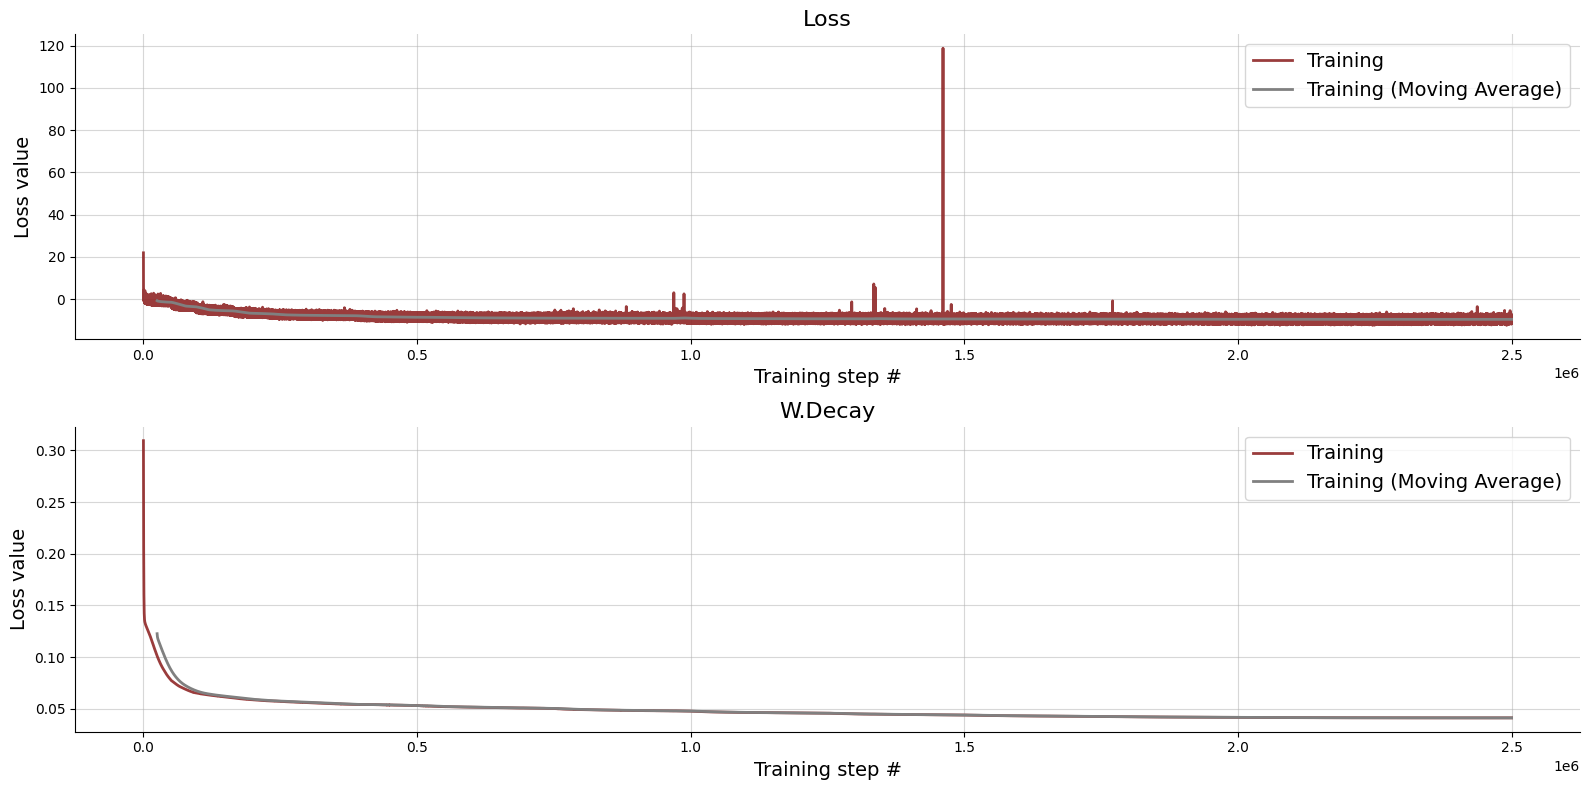

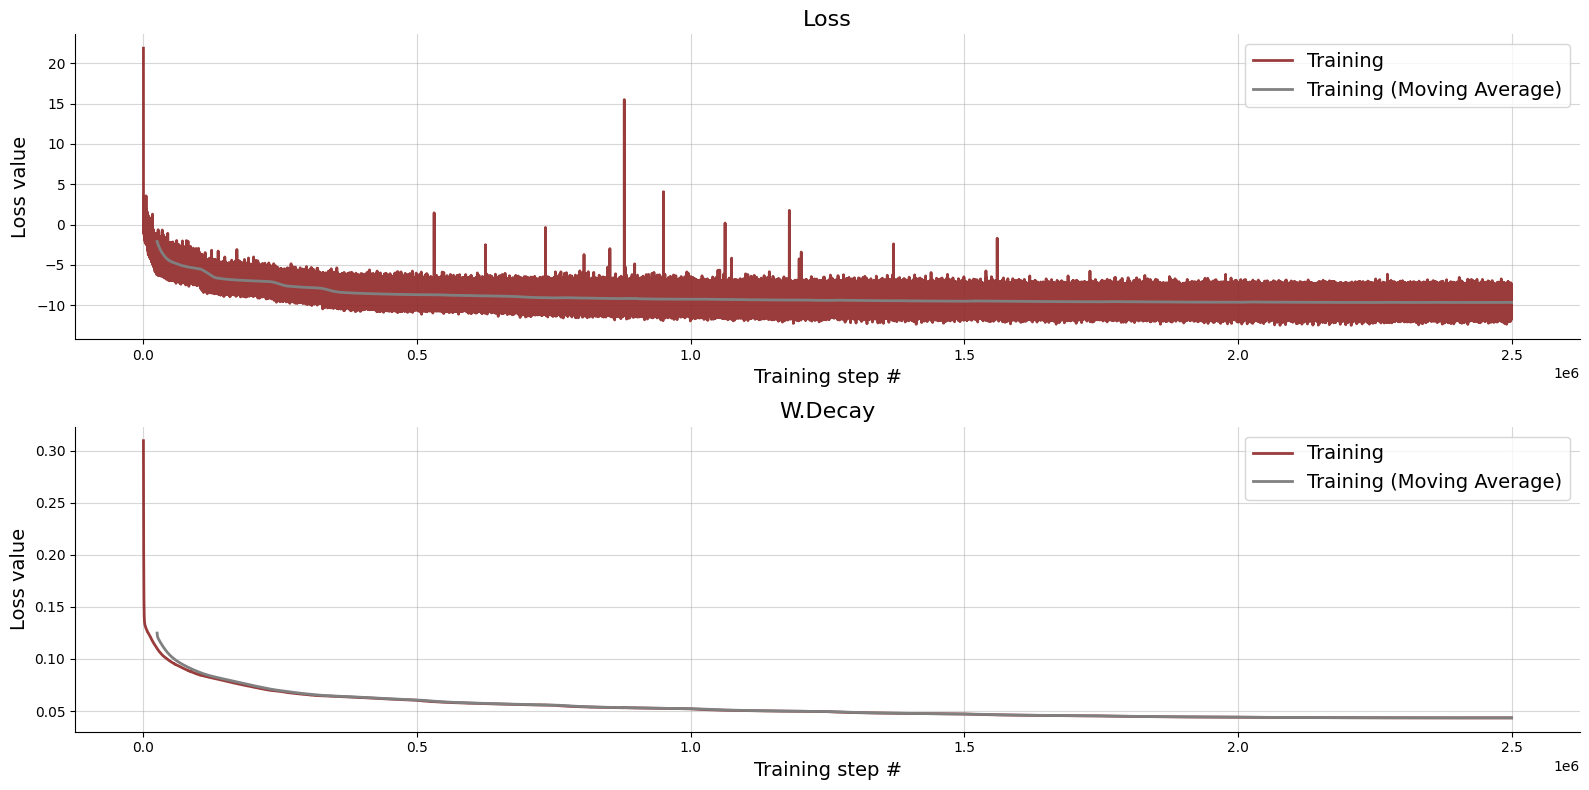

In [23]:
# Iterate over ensemble members (networks): training
for network in range(NUM_ENSEMBLE_MEMBERS):
    amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net{network + 1}")
    
    if not os.path.exists(f"checkpoint_{MY_NAME}/net{network + 1}"): # Disables further training when net was loaded from checkpoint
        if TRAINING_MODE == "presimulation":
            if RUNNER == "pc1":
                losses = trainer.train_from_presimulation(FULL_PRESIM_PATH, 
                                                          optimizer = optimizer, 
                                                          reuse_optimizer=True
                                                         )
            else: 
                losses = trainer.train_from_presimulation(FULL_PRESIM_PATH, 
                                                          optimizer = optimizer, 
                                                          reuse_optimizer=True, 
                                                          custom_loader=multipickle_loader
                                                         )
        else:
            losses = trainer.train_online(epochs=NUM_EPOCHS, iterations_per_epoch=NUM_ITERATIONS_PER_EPOCH, batch_size=BATCH_SIZE)

    f = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable(), moving_average=True)
    #f.savefig("figures/" + MY_NAME + "_net" +str(network + 1)+ "_losses.png")

## Post Training

### Inspect Losses

In [24]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net{network + 1}")
    my_history_net = trainer.loss_history.get_plottable()

    print("Network", network+1)
    print("shape:", my_history_net.shape)
    print(my_history_net.tail(10))

    first_nan_index = my_history_net['Loss'].isna().idxmax()
    last_valid_index_loss = my_history_net['Loss'].last_valid_index()
    last_valid_value_loss = my_history_net.at[last_valid_index_loss, 'Loss']
    print('Last valid value:', last_valid_value_loss)
    print('Last valid index:', last_valid_index_loss)

    following_rows = my_history_net.loc[last_valid_index_loss+1:]
    print('All following values are invalid' if following_rows.isna().all(axis=1).all() and first_nan_index!=0 else 'All values are valid')

INFO:root:Loaded loss history from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net1/history_250.pkl.
INFO:root:Networks loaded from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net1/ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Network 1
shape: (2500000, 2)
              Loss   W.Decay
2499990  -7.853759  0.041219
2499991  -9.103647  0.041219
2499992  -9.174334  0.041219
2499993 -10.092789  0.041219
2499994 -10.609015  0.041219
2499995 -10.339644  0.041219
2499996  -7.962292  0.041219
2499997 -10.021726  0.041219
2499998  -9.442876  0.041219
2499999 -10.310316  0.041219
Last valid value: -10.310316
Last valid index: 2499999
All values are valid


INFO:root:Loaded loss history from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net2/history_250.pkl.
INFO:root:Networks loaded from checkpoint_ttj_presimulation_250ep_10000it_levy_ddm_deadline/net2/ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Network 2
shape: (2500000, 2)
              Loss   W.Decay
2499990  -7.912913  0.043441
2499991  -8.899899  0.043441
2499992  -9.097145  0.043441
2499993 -10.062929  0.043441
2499994 -10.351700  0.043441
2499995 -10.080364  0.043441
2499996  -8.296494  0.043441
2499997 -10.207207  0.043441
2499998  -9.444731  0.043441
2499999 -10.342642  0.043441
Last valid value: -10.342642
Last valid index: 2499999
All values are valid


# Validation

In [25]:
# File paths
VAL_ROOT_PATH = "validation_files"
os.makedirs(VAL_ROOT_PATH, exist_ok=True)
VAL_SIMS_FILE = VAL_ROOT_PATH + "/val_sims_list_" + MY_NAME + ".pkl"
PRIOR_SAMPLES_FILE = VAL_ROOT_PATH + "/prior_samples_" + MY_NAME + ".pkl"
POST_SAMPLES_FILE = VAL_ROOT_PATH + "/post_samples_" + MY_NAME + ".pkl"

def save_data(data, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(data, f)

def load_data(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

# Check if files exist and load if possible, otherwise create
if all(os.path.exists(file) for file in [VAL_SIMS_FILE, PRIOR_SAMPLES_FILE, POST_SAMPLES_FILE]):
    print("Loading previously saved data...")
    val_sims_list = load_data(VAL_SIMS_FILE)
    prior_samples = load_data(PRIOR_SAMPLES_FILE)
    post_samples = load_data(POST_SAMPLES_FILE)
    print("Data loaded succesfully.")
else:
    print("Generating new data...")

    # Configuration and prior/simulator setup
    PRIOR_CONFIGS = {
        "levy": bf.simulation.Prior(batch_prior_fun=partial(prior_simulator_functions.levy_prior, fix_alpha=False), param_names=PARAM_NAMES),
        "ddm": bf.simulation.Prior(batch_prior_fun=partial(prior_simulator_functions.levy_prior, fix_alpha=True), param_names=PARAM_NAMES),
    }
    SIMULATOR_CONFIGS = {
        "no_deadline": bf.simulation.Simulator(batch_simulator_fun=partial(prior_simulator_functions.batch_simulator, deadline=False)),
        "deadline": bf.simulation.Simulator(batch_simulator_fun=partial(prior_simulator_functions.batch_simulator, deadline=True)),
    }

    # Initialize list to hold validation simulation results
    val_sims_list = []

    # Function to configure and append data
    def configure_and_append(prior_context, sim_context, num_sims=NUM_VAL_SIMS_PER_COMBINATION):
        prior = PRIOR_CONFIGS[prior_context]
        simulator = SIMULATOR_CONFIGS[sim_context]
        generative_model_combination = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, skip_test=True)
        val_data_combination = generative_model_combination(batch_size=num_sims)
        val_data_combination['prior_non_batchable_context'] = 0 if prior_context == "levy" else 1
        val_data_combination['sim_non_batchable_context'] = 0 if sim_context == "no_deadline" else 1
        configured_val_data_combination = configurator(val_data_combination)
        val_sims_list.append(configured_val_data_combination)

    # Generate validation data for each combination of contexts
    for prior_context, sim_context in itertools.product(PRIOR_CONTEXTS, SIMULATOR_CONTEXTS):
        configure_and_append(prior_context, sim_context)

    # Extract prior samples and generate posterior samples for each combination
    prior_samples = [val_data_combination["parameters"] for val_data_combination in val_sims_list]

    post_samples = []
    for network in range(NUM_ENSEMBLE_MEMBERS):
        amortizer, trainer, optimizer = setup_network(checkpoint_path=f"checkpoint_{MY_NAME}/net{network + 1}")
        network_samples = [amortizer.sample(val_data_combination, n_samples=NUM_VAL_SAMPLES) for val_data_combination in val_sims_list]
        post_samples.append(network_samples)

    # Save data to files
    print("Saving data...")
    save_data(val_sims_list, VAL_SIMS_FILE)
    save_data(prior_samples, PRIOR_SAMPLES_FILE)
    save_data(post_samples, POST_SAMPLES_FILE)
    print("Data saved successfully.")

Loading previously saved data...
Data loaded succesfully.


levy; deadline; network 1


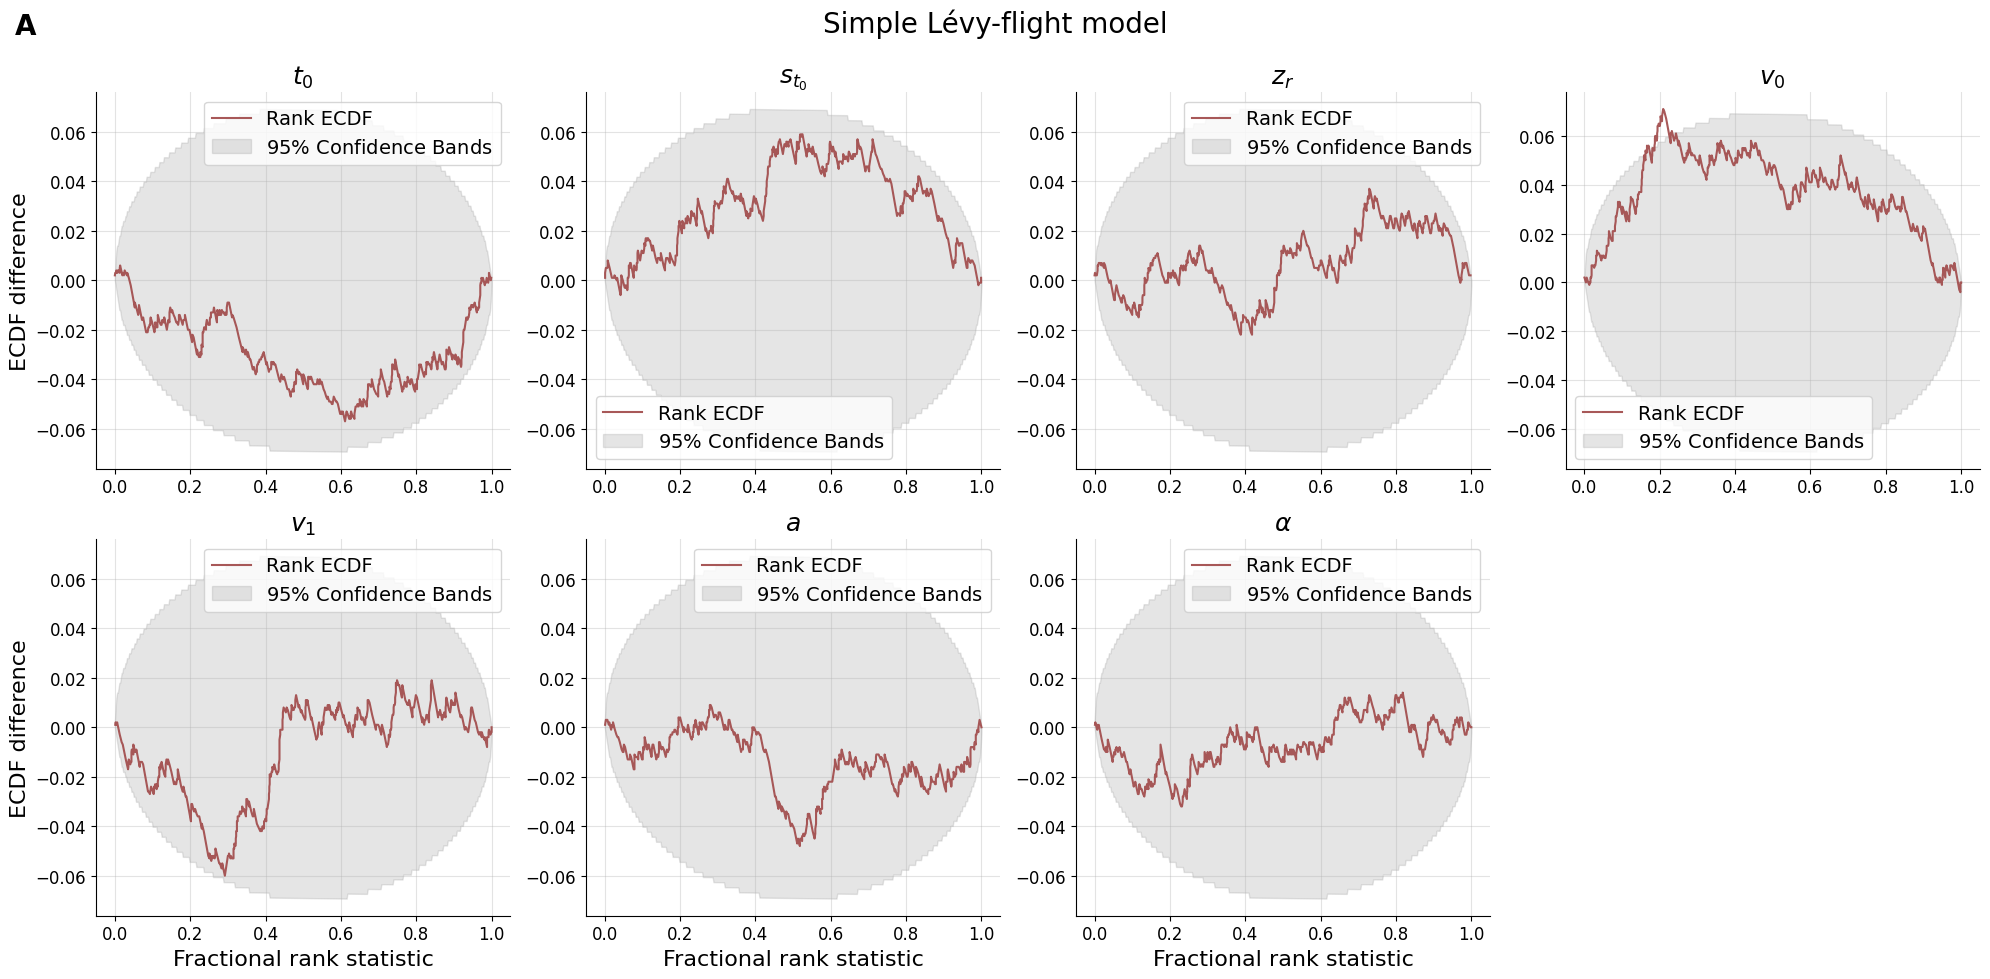

levy; deadline; network 2


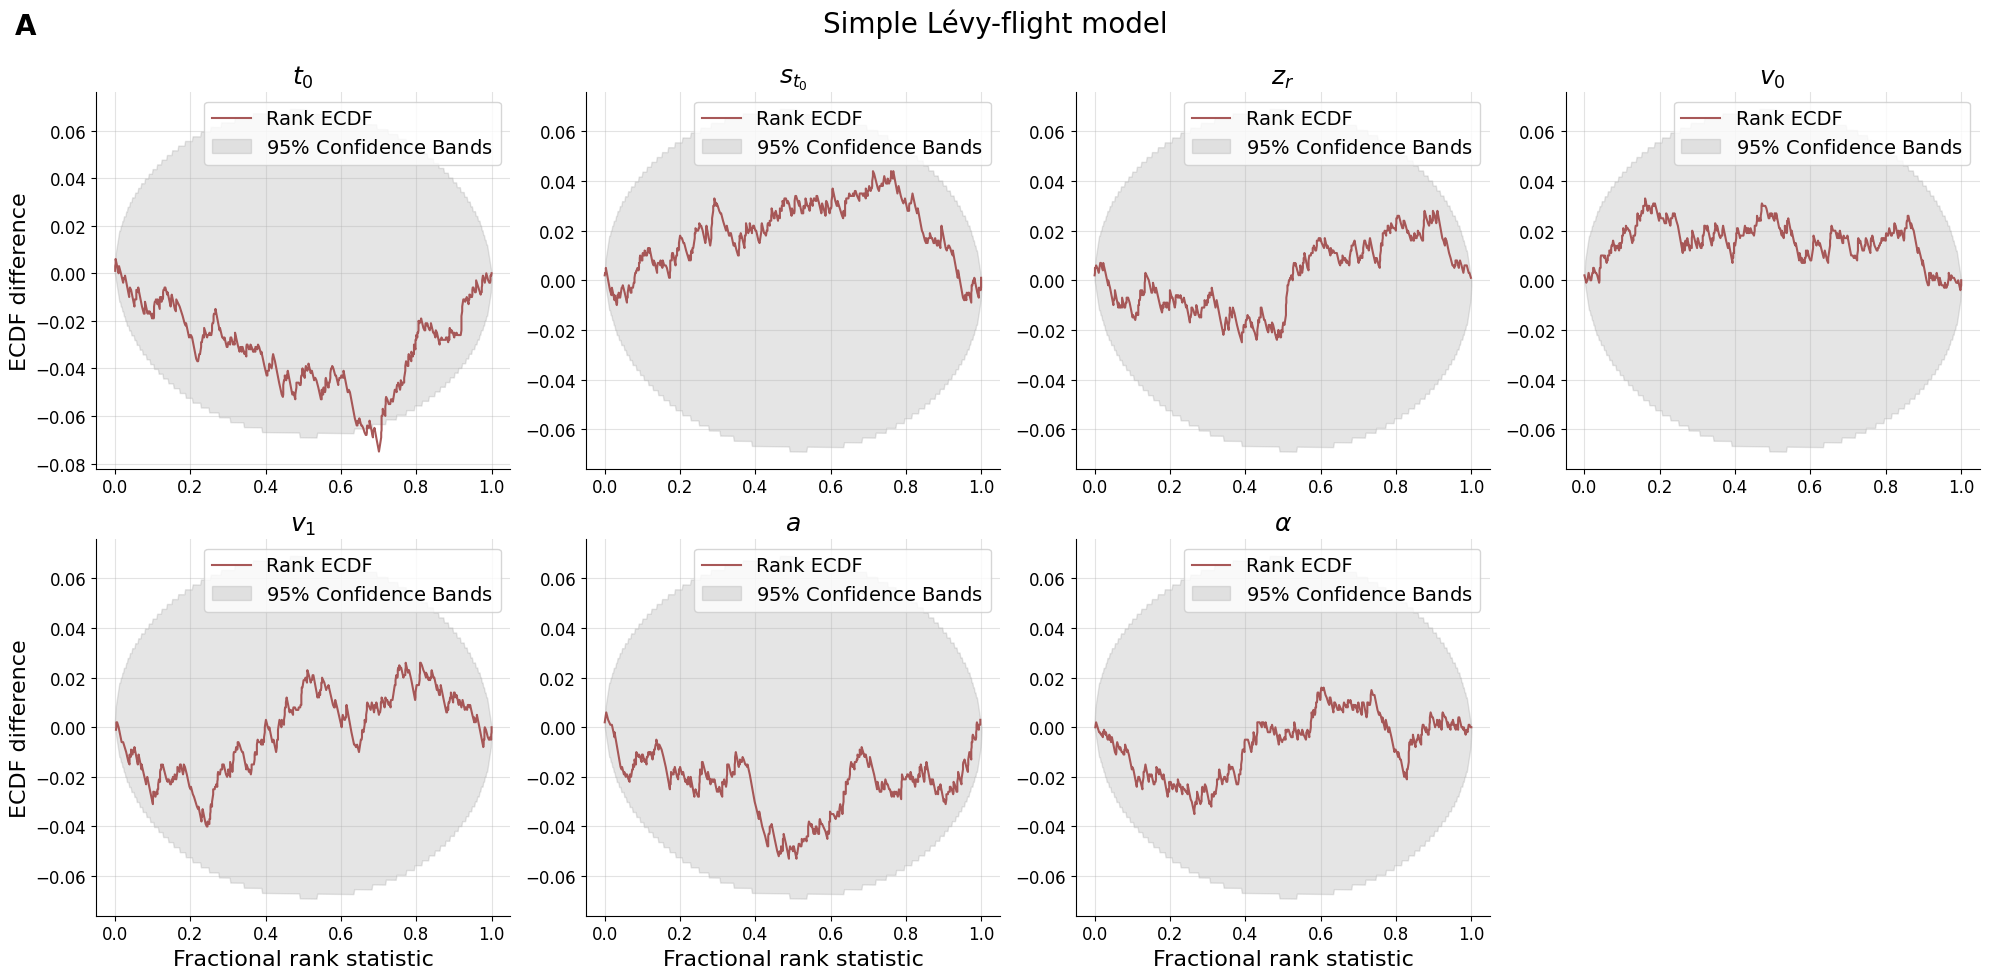

ddm; deadline; network 1


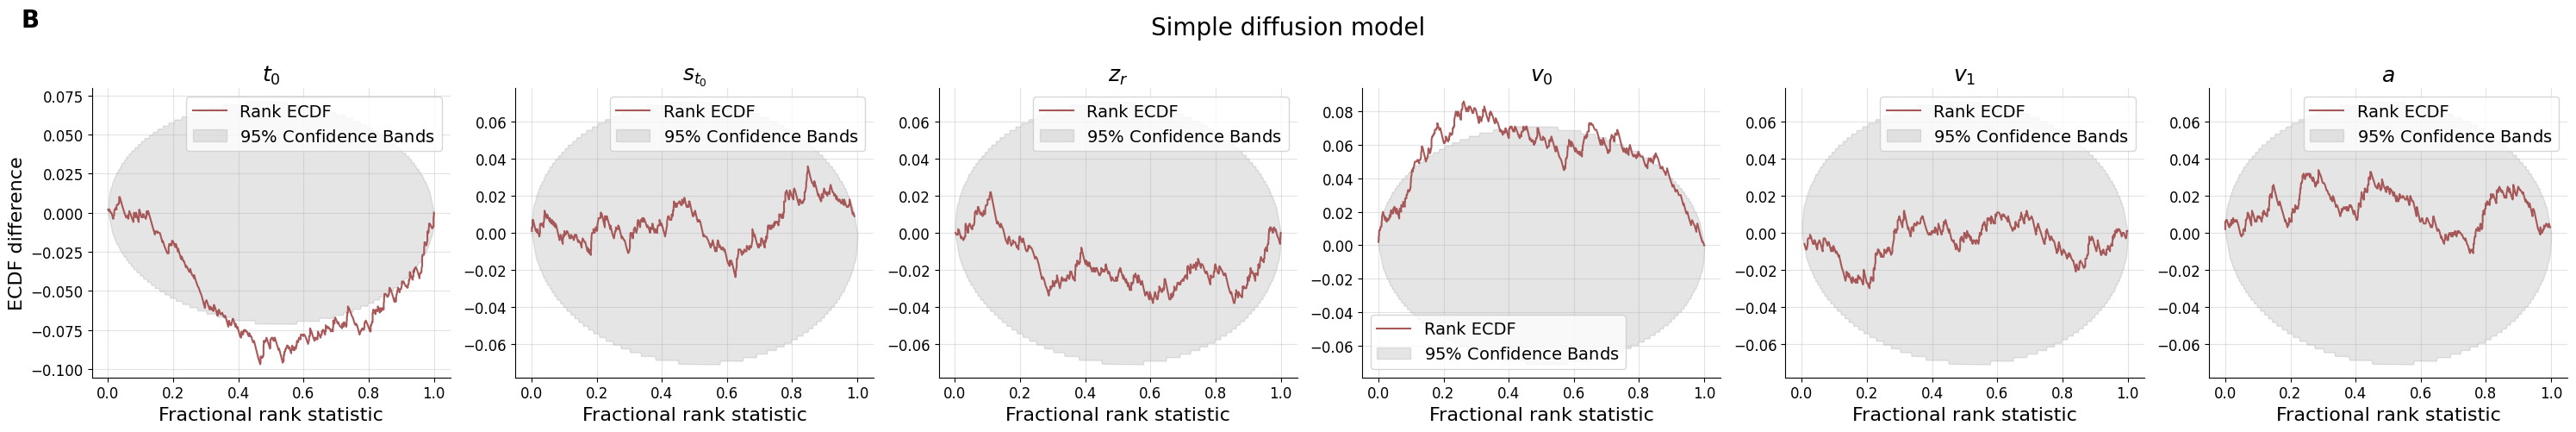

ddm; deadline; network 2


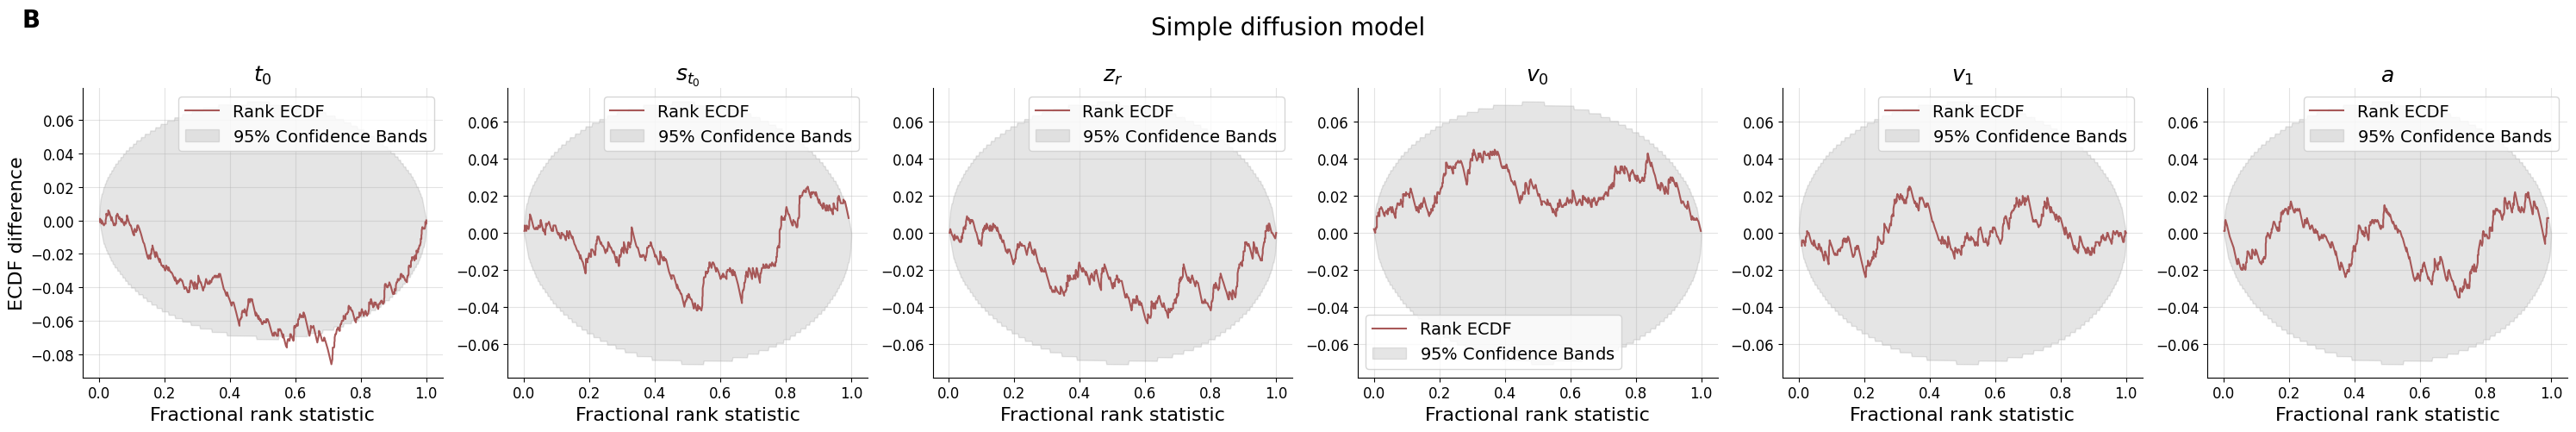

In [26]:
# SBC ECDFs
must_edit = 0
for c in range(NUM_COMBINATIONS):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        comp_model = "ddm" if val_sims_list[c]["direct_conditions"][0, 1] else "levy"
        condition = "deadline" if val_sims_list[c]["direct_conditions"][0, 2] else "no_deadline"
        
        # Modify data and parameter labels if comp_model is "ddm" to hide dummy
        if comp_model == "ddm" and must_edit==0:
            post_samples_mod = post_samples[network][c][..., :-1]  
            prior_samples_mod = prior_samples[c][..., :-1]        
            param_names = PARAM_LABELS[:6]  
        else:
            post_samples_mod = post_samples[network][c]
            prior_samples_mod = prior_samples[c]
            param_names = PARAM_LABELS
            
        f = bf.diagnostics.plot_sbc_ecdf(
            post_samples_mod, prior_samples_mod,
            stacked=False, difference=True, param_names=param_names,
            n_row=2, n_col=4 
        )
        
        f.suptitle(f'Simple {model_map.get(comp_model)} model', fontsize=20, y=0.975)
        annotation = "A" if comp_model == "levy" else "B"
        f.text(0.01, 0.95, annotation, fontsize=20, ha='left', fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.98])

        if comp_model == "ddm" and must_edit:
            filename = f"figures/ecdf_net{network+1}_{comp_model}_{condition}_edit.png"
        else:
            filename = f"figures/ecdf_net{network+1}_{comp_model}_{condition}.png"
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=MY_DPI)

        print(f'{comp_model}; {condition}; network {network + 1}')
        plt.show()

In [27]:
def filter_nan_post_samples(post_samples, prior_samples, num_combinations, num_ensemble_members):
    """
    Filters out NaN posterior samples (if present) so that plot_recovery does not crash; reports the number, fraction 
    and corresponding prior samples of NaN posterior samples.

    Parameters:
    -----------
    post_samples : nested list of numpy.ndarrays 
        Posterior samples to filter.
        Hierarchy/shape: (num_network)(num_combinations)(num_datasets, num_samples, num_parameters)
    num_combinations : int
        Number of condition combinations.
    num_ensemble_members : int
        Number of ensemble members.

    Returns:
    --------
    post_samples_filtered : numpy.ndarray
        Filtered posterior samples without NaN.
    """
    post_samples_filtered = copy.deepcopy(post_samples)

    for c in range(num_combinations):
        for network in range(num_ensemble_members):
            nan_mask = np.isnan(post_samples_filtered[network][c])
            
            if np.any(nan_mask):
                nan_fraction = nan_mask.sum() / post_samples_filtered[network][c].size
                num_parameters = post_samples_filtered[network][c].shape[-1]
                print(f"Number of NaN samples in network {network + 1}, condition {c + 1}: {nan_mask.sum() / num_parameters}")
                print(f"Fraction of NaNs in network {network + 1}, condition {c + 1}: {nan_fraction}")
                
                nan_dataset_indices = np.any(nan_mask, axis=1)
                nan_sample_indices = np.any(nan_mask, axis=(0, 2))
                print(f"NaN in posterior samples for following prior samples: {prior_samples[c][nan_dataset_indices]}")
                post_samples_filtered[network][c] = post_samples_filtered[network][c][:, ~nan_sample_indices, :]

    return post_samples_filtered

post_samples_filtered = filter_nan_post_samples(
    post_samples=post_samples,
    prior_samples=prior_samples,
    num_combinations=NUM_COMBINATIONS,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS
)

levy; deadline; network 1


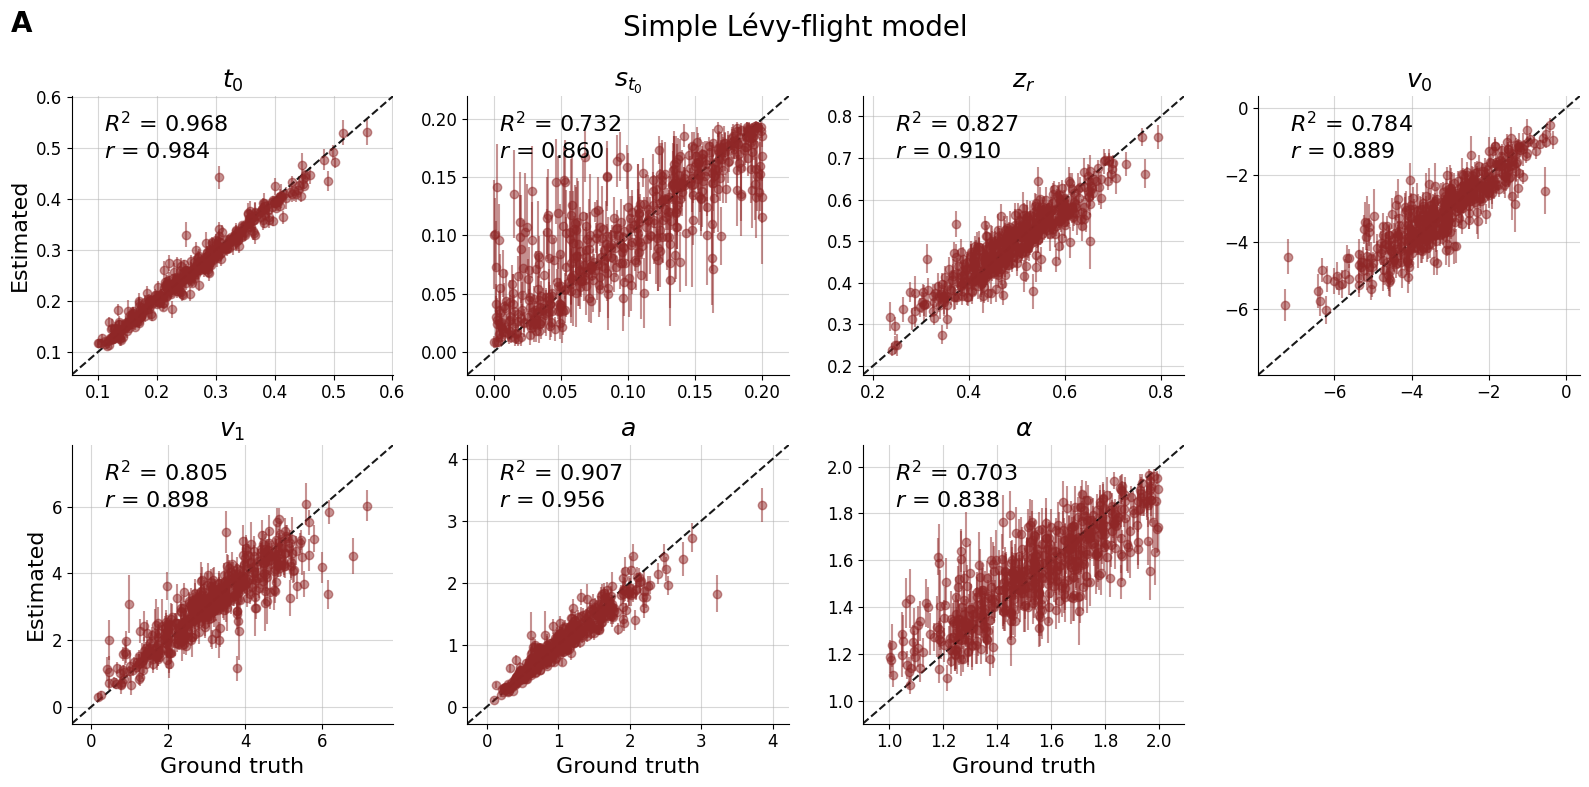

levy; deadline; network 2


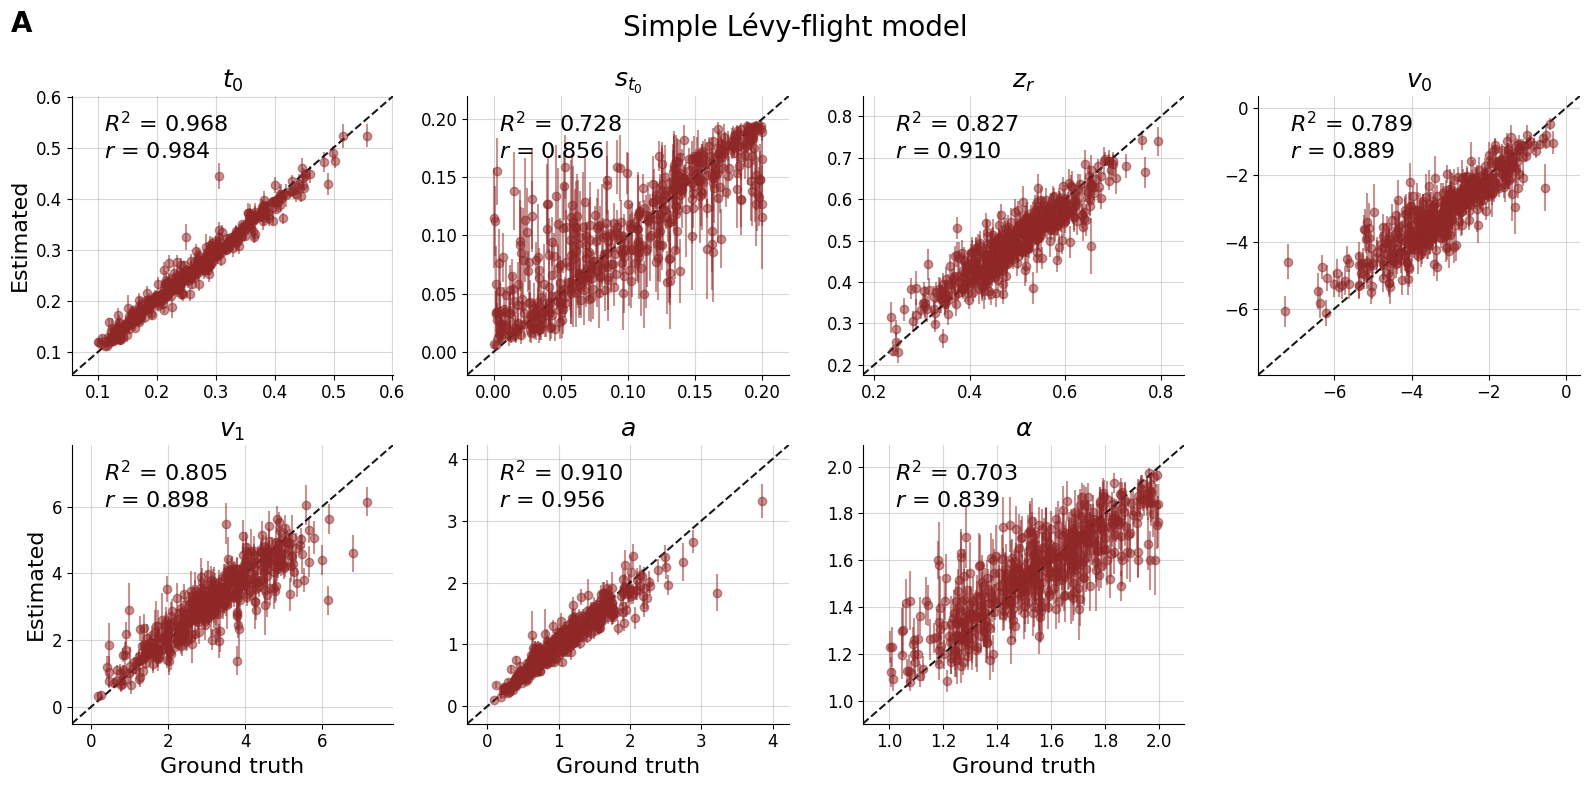

ddm; deadline; network 1


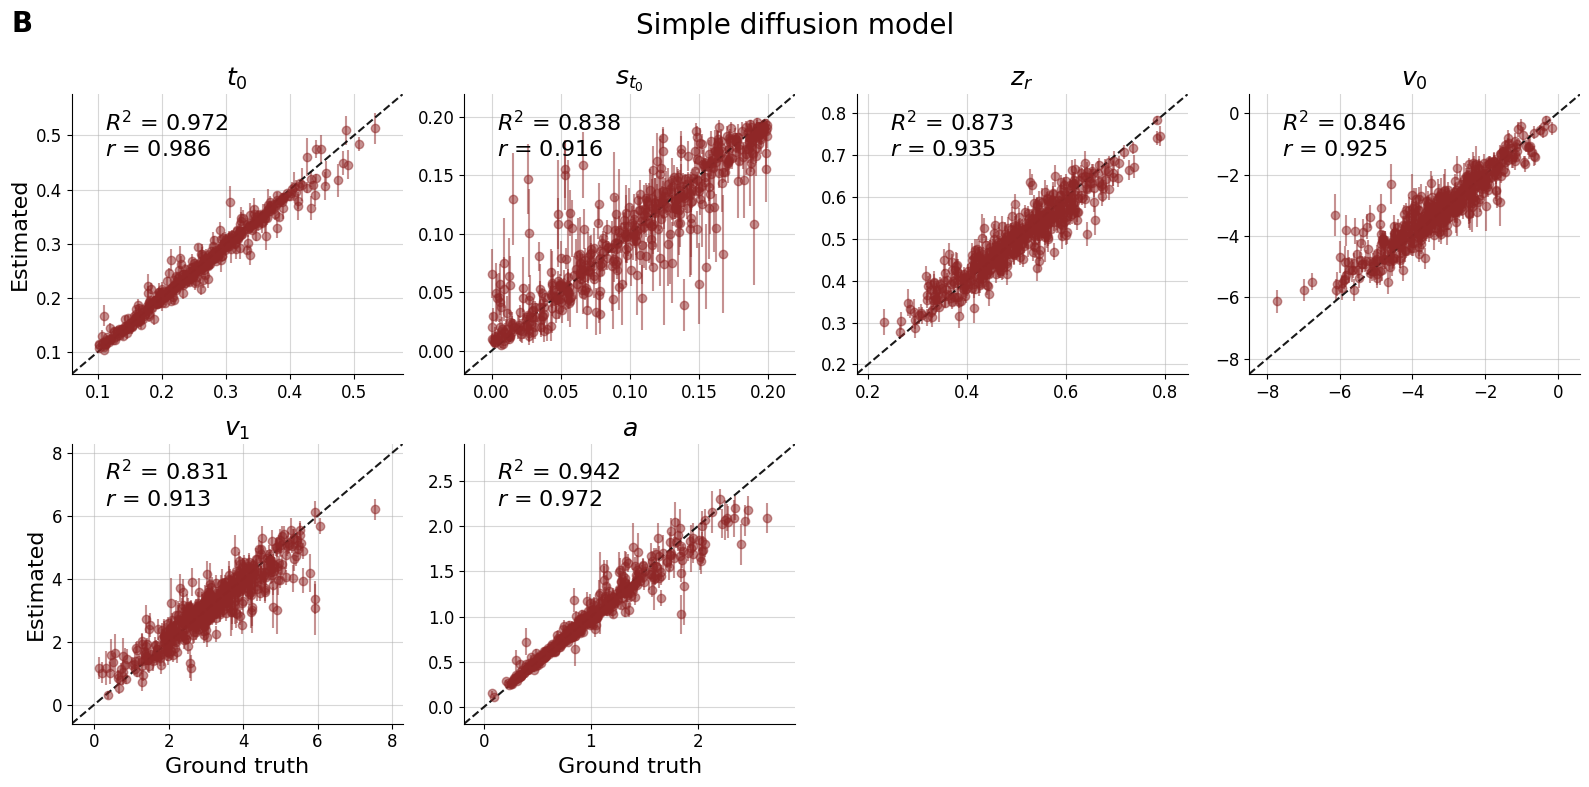

ddm; deadline; network 2


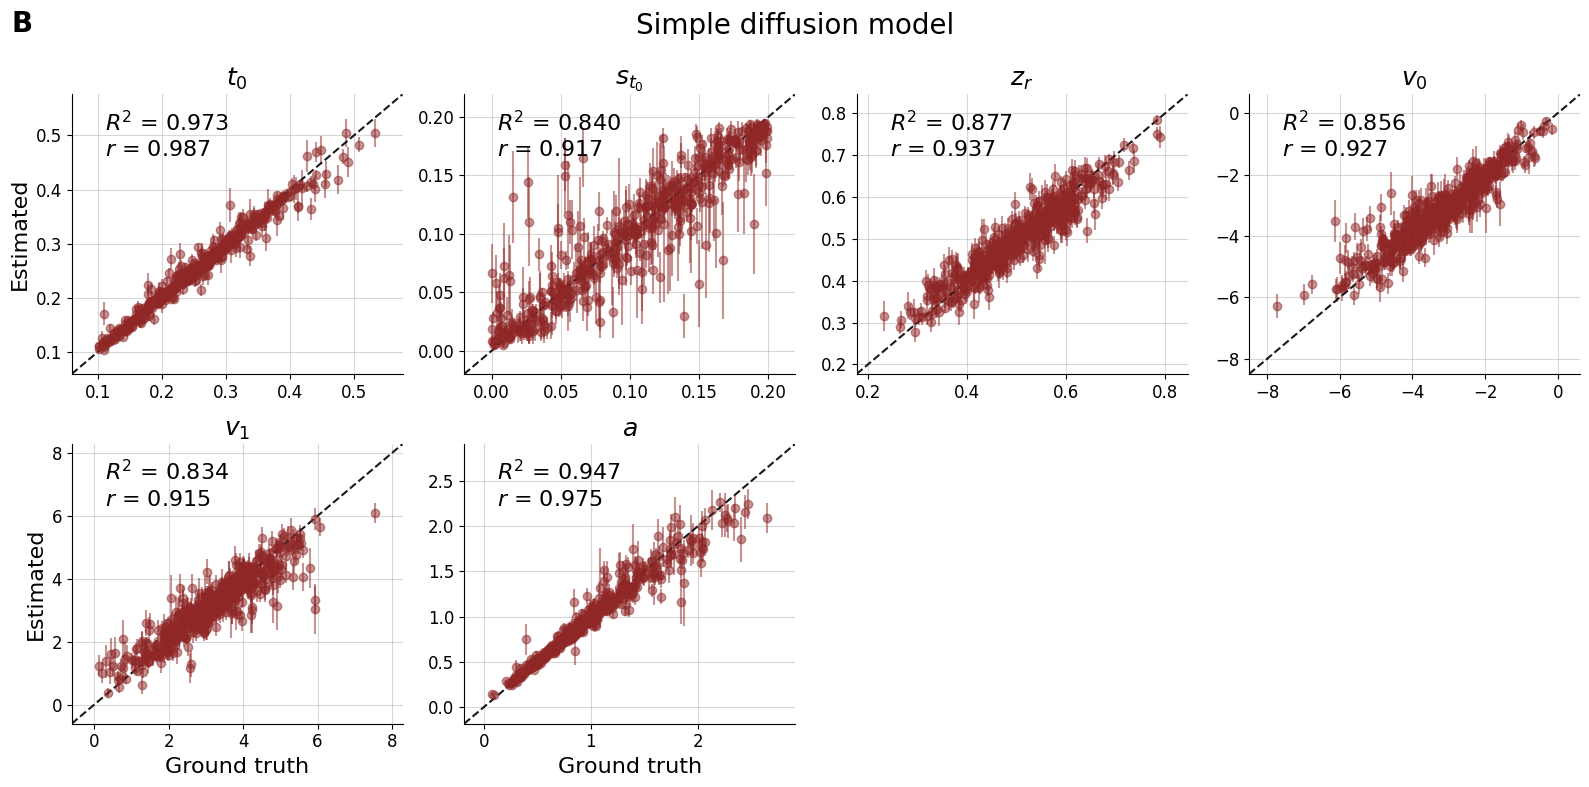

In [28]:
# Median posterior recovery
for c in range(NUM_COMBINATIONS):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        comp_model = "ddm" if val_sims_list[c]["direct_conditions"][0, 1] else "levy"
        condition = "deadline" if val_sims_list[c]["direct_conditions"][0, 2] else "no_deadline"

        # Modify data and parameter labels if comp_model is "ddm"
        if comp_model == "ddm":
            post_samples_mod = post_samples_filtered[network][c]
            post_samples_mod = post_samples_mod[..., :-1]  
            prior_samples_mod = prior_samples[c][..., :-1]        
            param_names = PARAM_LABELS[:6] 
        else:
            post_samples_mod = post_samples[network][c]
            prior_samples_mod = prior_samples[c]
            param_names = PARAM_LABELS
        
        f = bf.diagnostics.plot_recovery(post_samples_mod, prior_samples_mod, param_names=param_names,
                                        n_row=2, n_col=4)
        
        f.suptitle(f'Simple {model_map.get(comp_model)} model', fontsize=20, y=0.975)
        annotation = "A" if comp_model == "levy" else "B"
        f.text(0.01, 0.95, annotation, fontsize=20, ha='left', fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.98])

        filename = f"figures/param_recovery_net{network+1}_{comp_model}_{condition}.png"
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=MY_DPI)

        print(f'{comp_model}; {condition}; network {network + 1}')
        plt.show()

levy; deadline; network 1


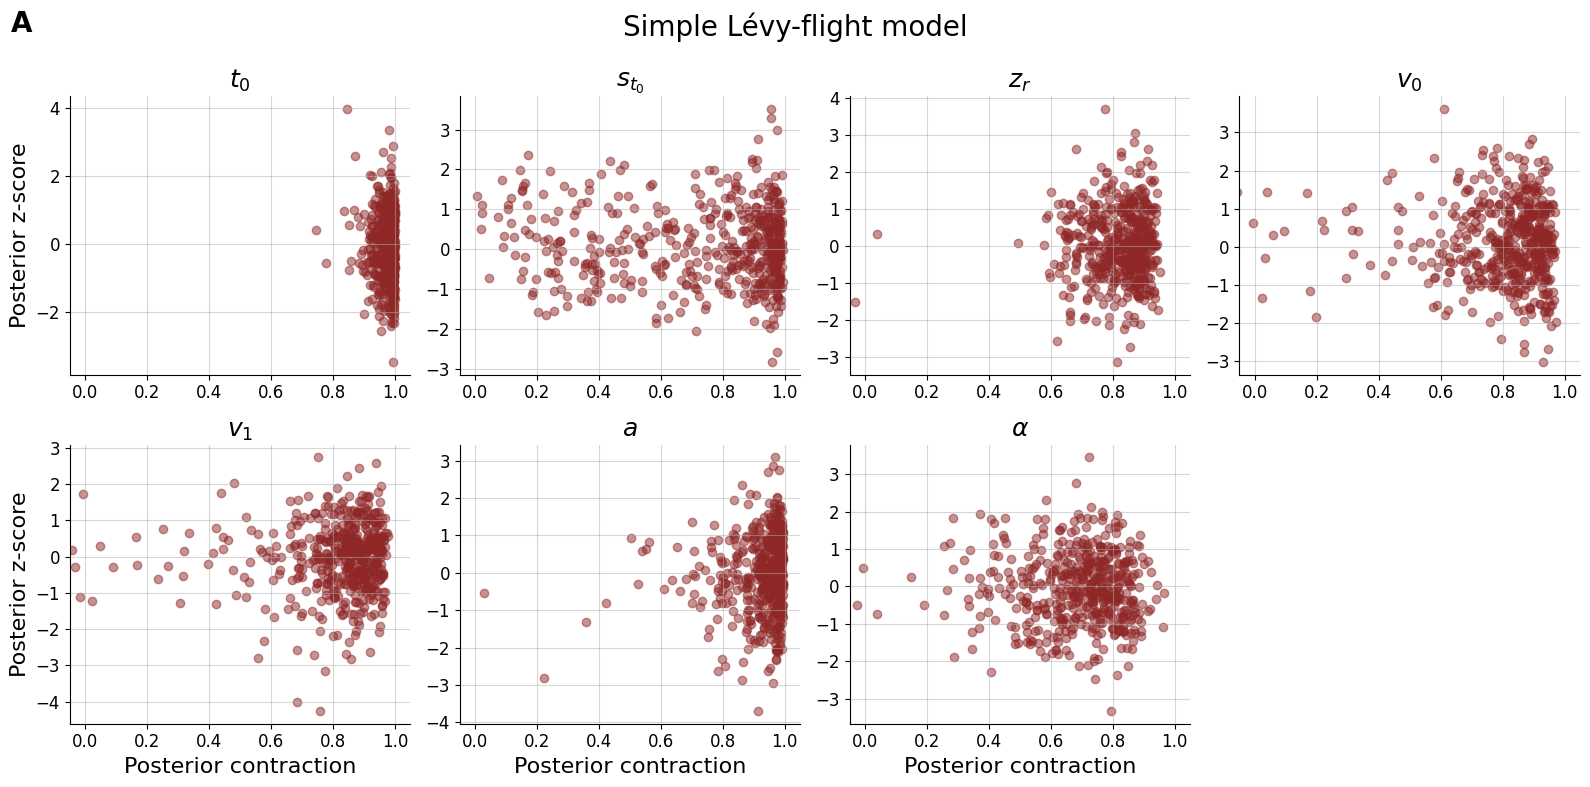

levy; deadline; network 2


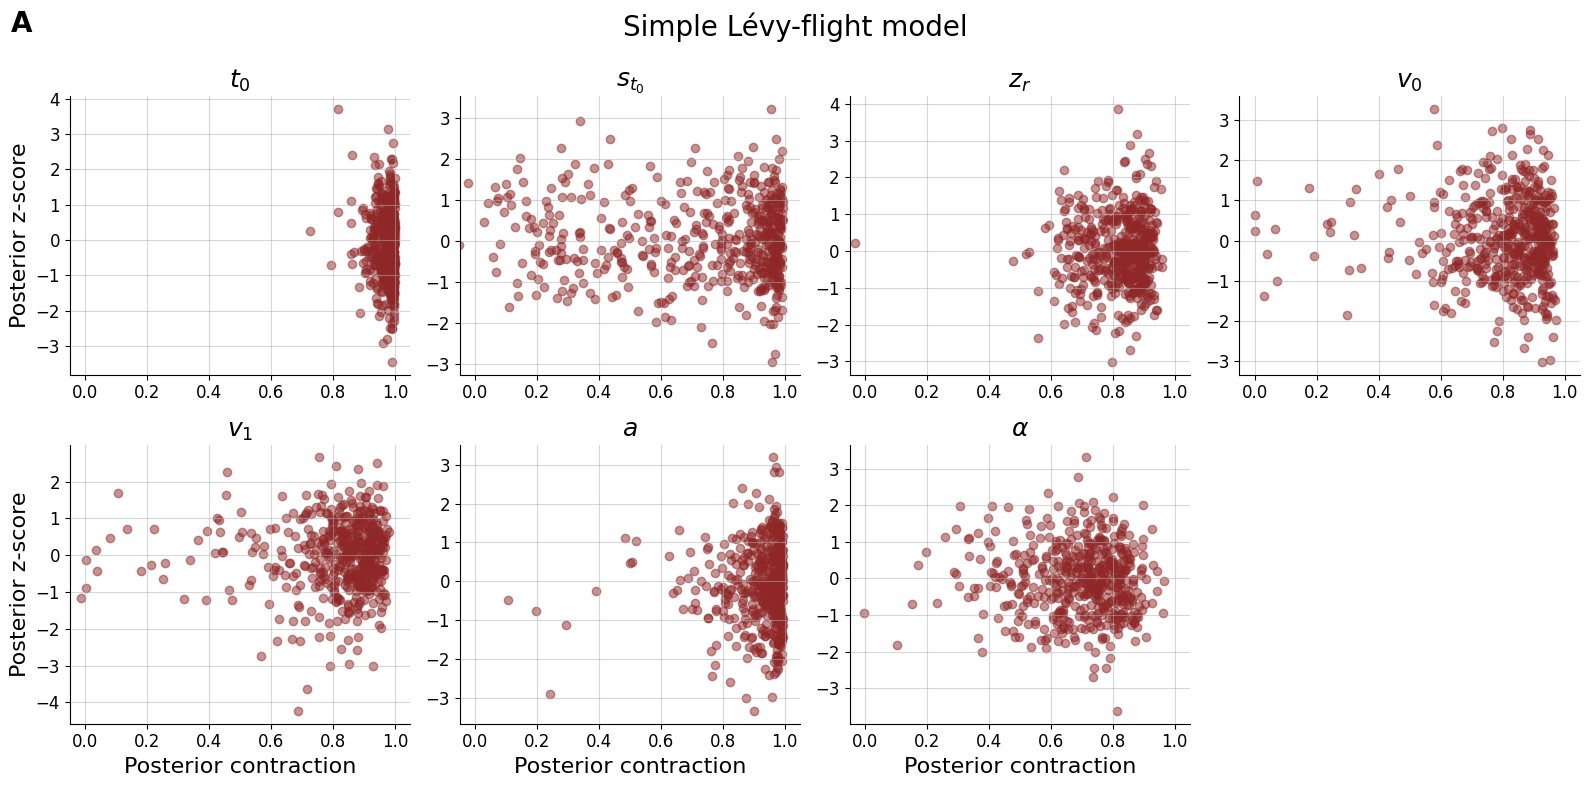

ddm; deadline; network 1


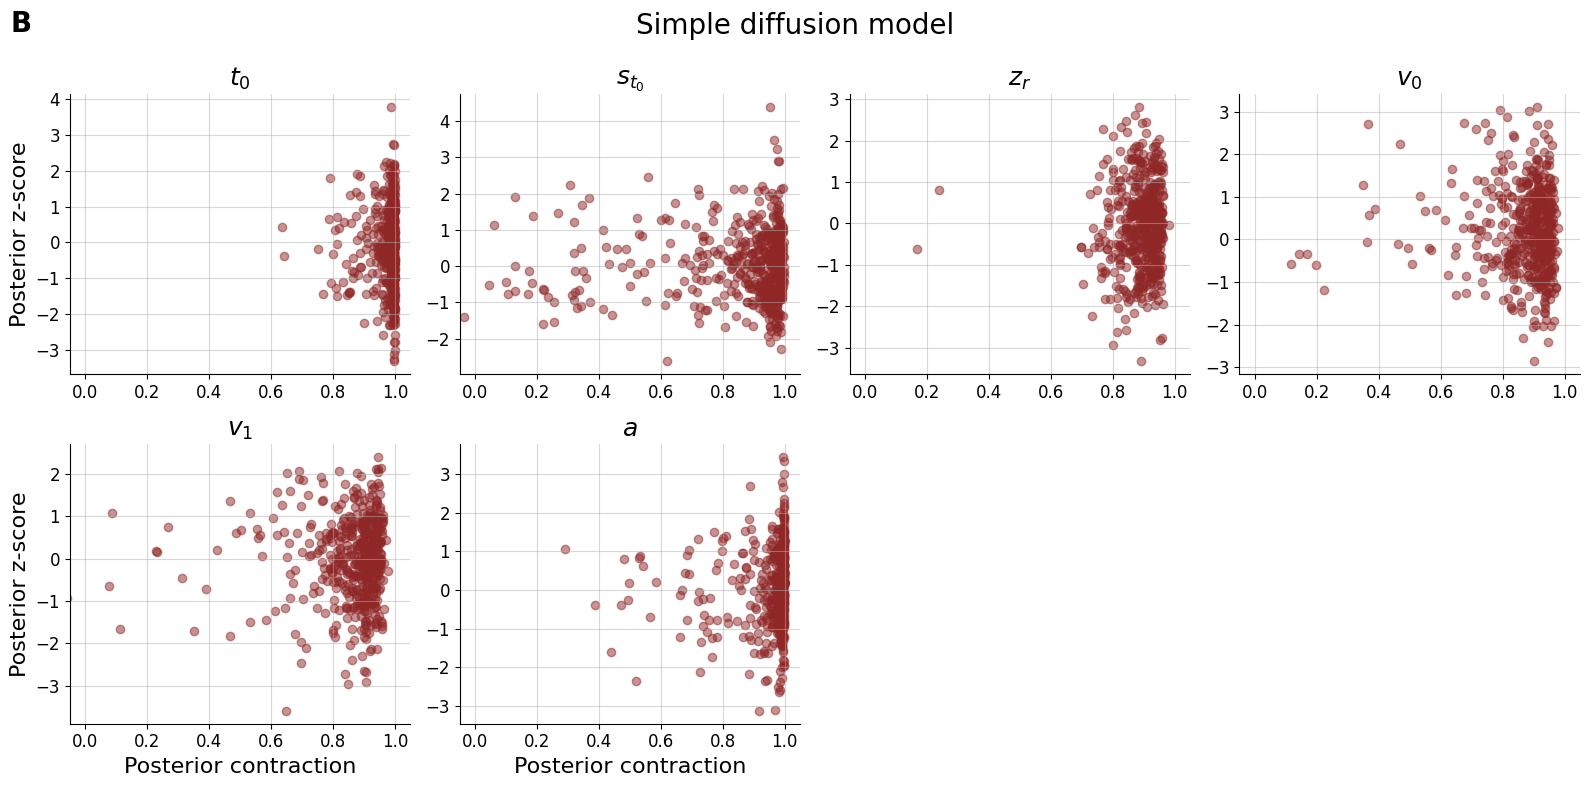

ddm; deadline; network 2


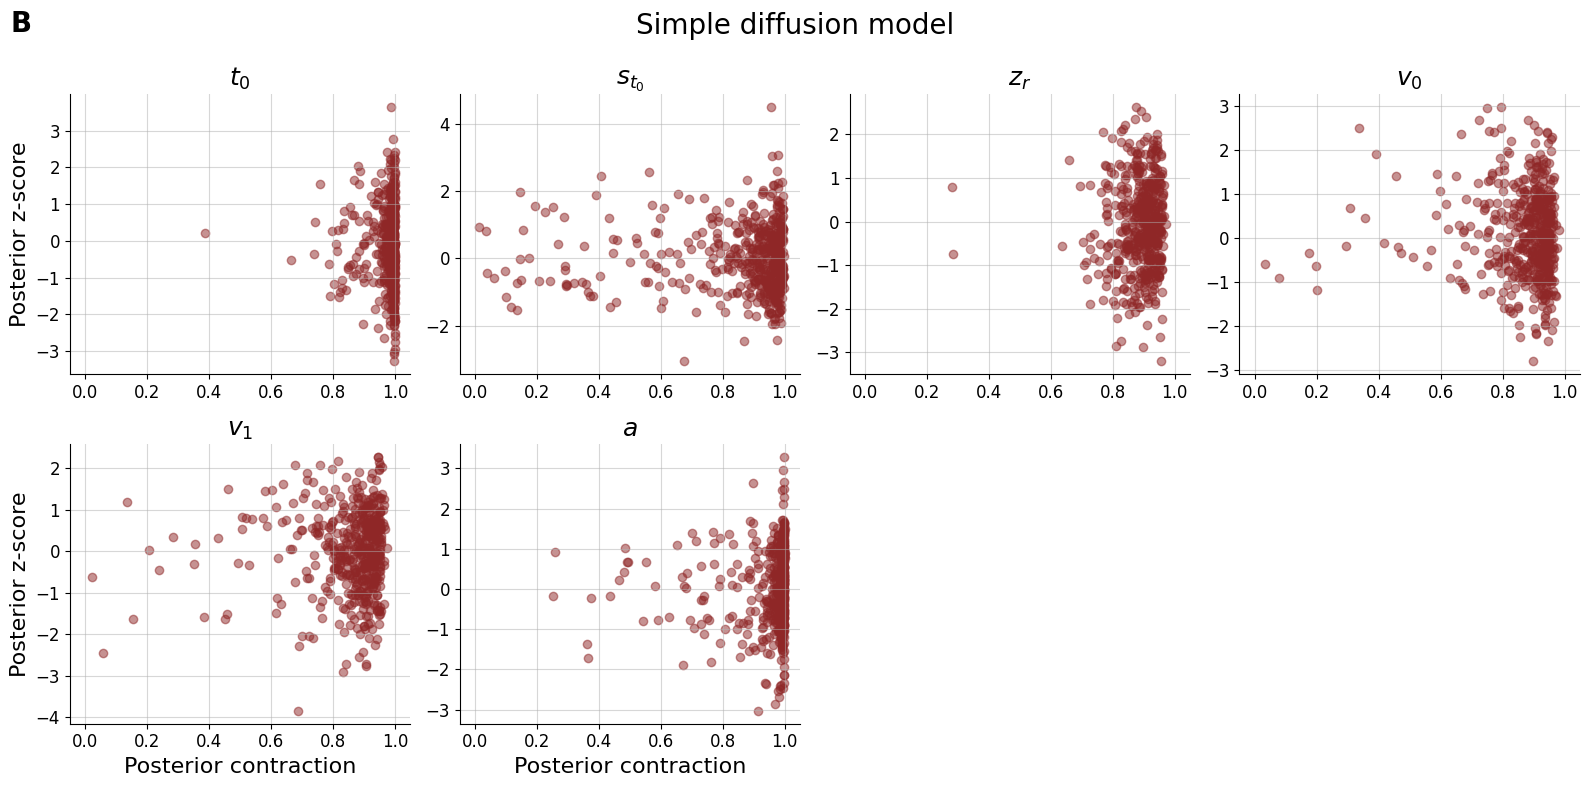

In [29]:
# Posterior contraction
for c in range(NUM_COMBINATIONS):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        comp_model = "ddm" if val_sims_list[c]["direct_conditions"][0, 1] else "levy"
        condition = "deadline" if val_sims_list[c]["direct_conditions"][0, 2] else "no deadline"

        # Modify data and parameter labels if comp_model is "ddm"
        if comp_model == "ddm":
            post_samples_mod = post_samples[network][c][..., :-1] 
            prior_samples_mod = prior_samples[c][..., :-1]
            param_names = PARAM_LABELS[:6] 
        else:
            post_samples_mod = post_samples[network][c]
            prior_samples_mod = prior_samples[c]
            param_names = PARAM_LABELS
            
        f = bf.diagnostics.plot_z_score_contraction(post_samples_mod, prior_samples_mod, 
                                                    param_names=param_names,
                                                   n_row=2, n_col=4
                                                   )

        f.suptitle(f'Simple {model_map.get(comp_model)} model', fontsize=20, y=0.975)
        annotation = "A" if comp_model == "levy" else "B"
        f.text(0.01, 0.95, annotation, fontsize=20, ha='left', fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.98])

        filename = f"figures/contraction_net{network+1}_{comp_model}_{condition}.png"
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=MY_DPI)

        print(f'{comp_model}; {condition}; network {network + 1}')
        plt.show()